# Mongo collections analysis

## Init

In [28]:
import pymongo, math, json, ast, datetime, time, os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from tqdm import tqdm

from config import Config

image_version = "2.2.1"
base_image_path = f"images/mongo_analysis/v{image_version}"
if f"v{image_version}" not in os.listdir("images/mongo_analysis"):
    os.mkdir(base_image_path)

image_path = f"images/mongo_analysis/v{image_version}"

def set_iamge_subpath(subpath):
    global image_path
    image_path = f"{base_image_path}/{subpath}"
    if subpath not in os.listdir(base_image_path):
        os.mkdir(image_path)
        

In [16]:
iamge_path

'images/mongo_analysis/v2.2.0/rdap'

In [2]:
# MongoDB connection settings (replace placeholders with your actual MongoDB connection details)
client = pymongo.MongoClient(Config.MONGO_URI)
db = client[Config.MONGO_DB]
benign = db.benign_2310
misp = db.misp_2311

### TODO

Lexikální
- [x] Histogram výskytů různých TLD
- [x] průměrná délka domény
- [x] průměrná entropie
- [x] Průměrný výskyt jednotlivých skupin znaků (písmenka, čísla, hex, ...)
- [x] Průměrná délka nejkratší, nejdelší, a průměrné části domény
- [x] Průměrný počet subdomén
- [x] Nejtypičtější bigramy a trigramy

IP
- [x]  informace o IP adresách, takže třeba kolik je průměrně IPv4 a IPv6 adres atd

DNS
- [ ] a počty záznamy různých ty
- [ ] o jak se tam pohybují ty ttl hodno
- [ ] y 
Hodně nám tam dominovala ta tls_root_cert_lifeti
- [ ] .. tak se třeba podívat, jak se to pohybuje u phishingových a benign
- [ ] .. jaká je doba platnosi (validity_e
 GEO
- x ] z jakých kontinent
- x ] z jakých  zemí ty domény jso.

## Domain

In [ ]:
set_iamge_subpath("lexical")

#### Fetch data from MongoDB

In [28]:
tlds_benign = list(benign.find({}, {'domain_name': 1}))
tlds_misp = list(misp.find({}, {'domain_name': 1}))

### TLDs

#### Definitions

In [19]:
image_path

'images/mongo_analysis/v2.2.0'

In [5]:
def calculate_column_distribution(df, column, min_percentage):
    """
    Calculate the Top-Level Domain (TLD) distribution in a DataFrame.

    Parameters:
    - df: DataFrame
        The DataFrame containing the 'tld' column.
    - min_percentage: float
        The minimum percentage threshold for considering TLDs.

    Returns:
    - pd.Series
        A Series containing the TLD distribution.
    """
    # Calculate the normalized counts of each column value
    values_counts = df[column].value_counts(normalize=True)
    # Filter column values based on the minimum percentage
    filtered_values = values_counts[values_counts >= min_percentage]
    filtered_values = round(filtered_values * 100, 2)
    # Calculate the sum of counts for column values below the threshold
    others_count = round(values_counts[values_counts < min_percentage].sum() * 100, 2)

    value_names, values_counts = zip(*list(filtered_values.items())+[("Other", others_count)])
    # Return the column values distribution
    return pd.DataFrame(data={
        "name": value_names,
        "count": values_counts
    })


def barplot_column_distribution(df, feature, name, **kwargs):
    plt.figure(figsize=(12, 8))
    horizontal = kwargs.get("orient") == 'h' 
    
    ax = sns.barplot(x="count", y="name", data=df, saturation=0.6, label=name, **kwargs)

    get_yticklabels = ax.get_xticklabels if horizontal else ax.get_yticklabels
    set_yticklabels = ax.set_xticklabels if horizontal else ax.set_yticklabels
    xlabel = plt.ylabel if horizontal else plt.xlabel
    ylabel = plt.xlabel if horizontal else plt.ylabel

    xlabel(feature)
    
    # Apply logarithmic scale if log_scale is True
    if kwargs.get("log_scale"):
        yticks_labels = [f"{pow(10, x-1)}%" for x in range(len(get_yticklabels()))]
        set_yticklabels(yticks_labels)
        ylabel(f'Percentage (log)')
    else:
        yticks_labels = [f"{x.get_text()}%" for x in get_yticklabels()]
        set_yticklabels(yticks_labels)
        ylabel('Percentage')

    plt.xticks(rotation=45)
        
    plt.title(f'{feature}s - {name}')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s - {name}_barplot.png")
    plt.savefig(f"{image_path}/{feature}s - {name}_barplot.pdf", format='pdf')
    plt.show()



def piechart_column_distribution(df, feature, name, color_map=plt.cm.Reds, legend=False, **kwargs):
    plt.figure(figsize=(12, 10))
    logged = np.log(df['count']*10)/5
    scaled = logged / max(logged) * 0.75
    colors = color_map(scaled)
    # total_size = sum(sizes)
    scaled=[0.5 for x in range(len(df))]
    wedges, texts, autotexts = plt.pie(df['count'], labels=df['name'], autopct='%1.1f%%', startangle=90, pctdistance=0.8)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
        # Hide labels around the circle
        for text in texts:
            text.set_visible(False)

    plt.title(f'{feature}s - {name}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    # plt.tight_layout()
    if legend:
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart_w_legend.png")
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart_w_legend.pdf", format="pdf")
    else:
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart.png")
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart.pdf", format="pdf")

    plt.show()


# Author: Radek Hranický
def piechart_column_distribution3(df, feature, name, color_map=plt.cm.tab10, legend=False, **kwargs):
    plt.figure(figsize=(10, 8))
    
    # Combine two different color maps
    color_map1 = plt.cm.tab20(np.linspace(0., 1., 20))
    color_map2 = plt.cm.tab10(np.linspace(0., 1., 12))  # tab10 has 12 distinct colors
    combined_colors = np.vstack((color_map1, color_map2))  # Stack the color maps

    # Assign colors to each category, ensuring 'Other' is set to grey
    colors = [combined_colors[i] if tld != "Other" else 'grey' for i, tld in enumerate(df['name'])]

    # Create the pie chart without autopct
    wedges, texts = plt.pie(df['count'], startangle=90, colors=colors, **kwargs)

    # Calculate the percentages and set up the labels
    percentages = [100. * c / sum(df['count']) for c in df['count']]
    labels = [f"{tld} $\\mathbf{{{pct:.1f}\\%}}$" for tld, pct in zip(df['name'], percentages)]

    # Annotate with TLD and percentage
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle),
                  horizontalalignment=horizontalalignment, size=12, va='center')

        plt.annotate(label, xy=(x, y), xytext=(1.5*x, 1.2*y), **kw)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)

    plt.title(f'{feature}s - {name}', fontsize=14)
    plt.axis('equal')

    # Adjust the margins and save the figure with enough space for the content
    plt.subplots_adjust(left=0.0, right=0.85, top=0.9, bottom=0.1)  # Adjust as needed
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png", bbox_inches='tight')
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf', bbox_inches='tight')

    plt.show()


#### Compute the values

In [31]:
# Create DataFrames
df_benign = pd.DataFrame(tlds_benign)
df_misp = pd.DataFrame(tlds_misp)

df_benign["tld"] = df_benign["domain_name"].apply(lambda x: x.split(".")[-1])
df_misp["tld"] = df_misp["domain_name"].apply(lambda x: x.split(".")[-1])


min_percentage = 0.005

# Calculate distributions
benign_tld_dist = calculate_column_distribution(df_benign, "tld", min_percentage)
misp_tld_dist = calculate_column_distribution(df_misp, "tld", min_percentage)


In [32]:
logged = np.log(benign_tld_dist['count']*10)/10
logged / max(logged) * 0.75

0     0.750000
1     0.605017
2     0.391875
3     0.338474
4     0.286008
5     0.283954
6     0.253334
7     0.217380
8     0.203815
9     0.195295
10    0.565321
Name: count, dtype: float64

#### Plot the results

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_11416\3969064512.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


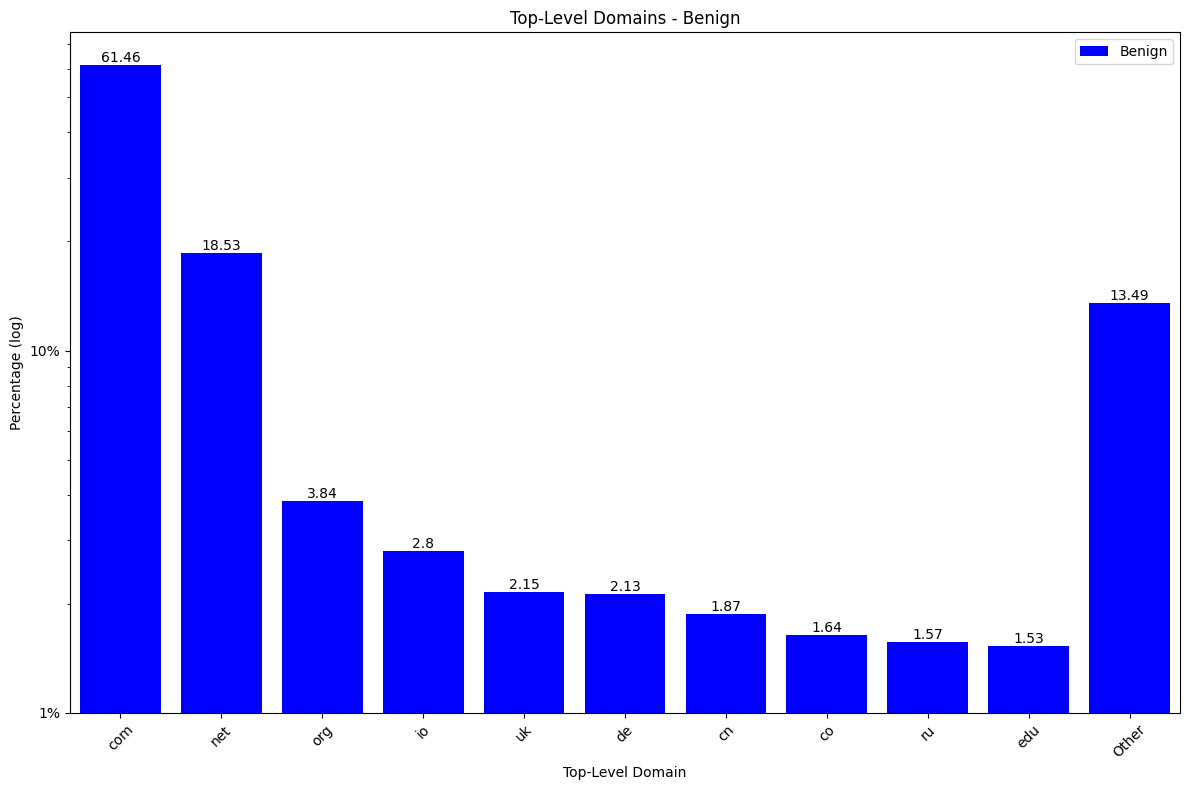

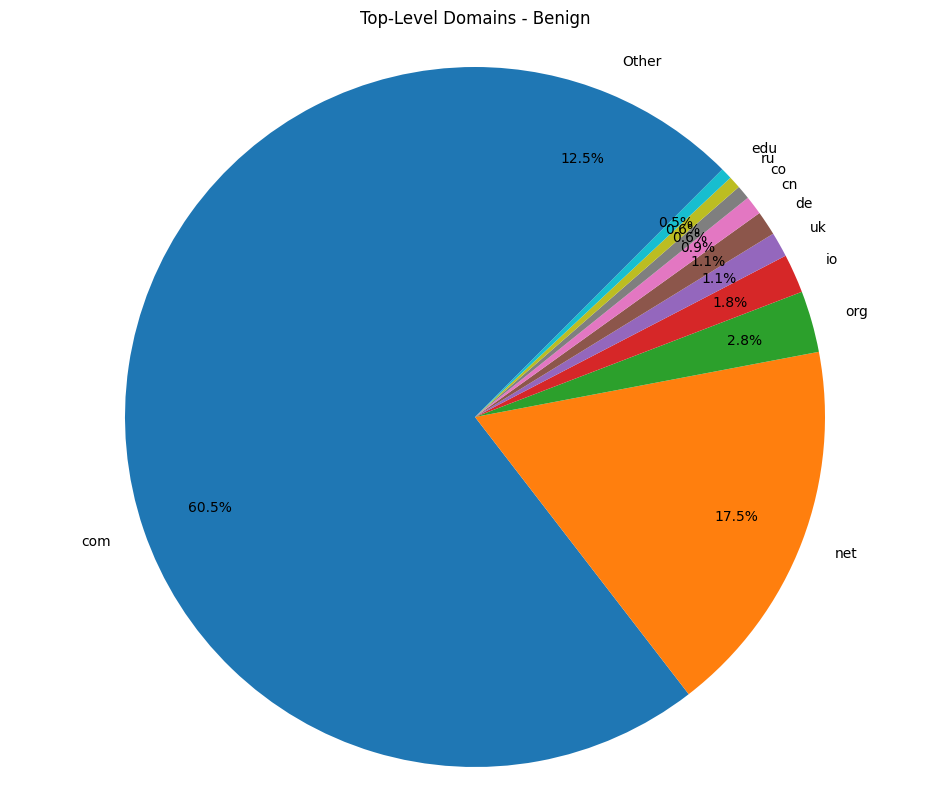

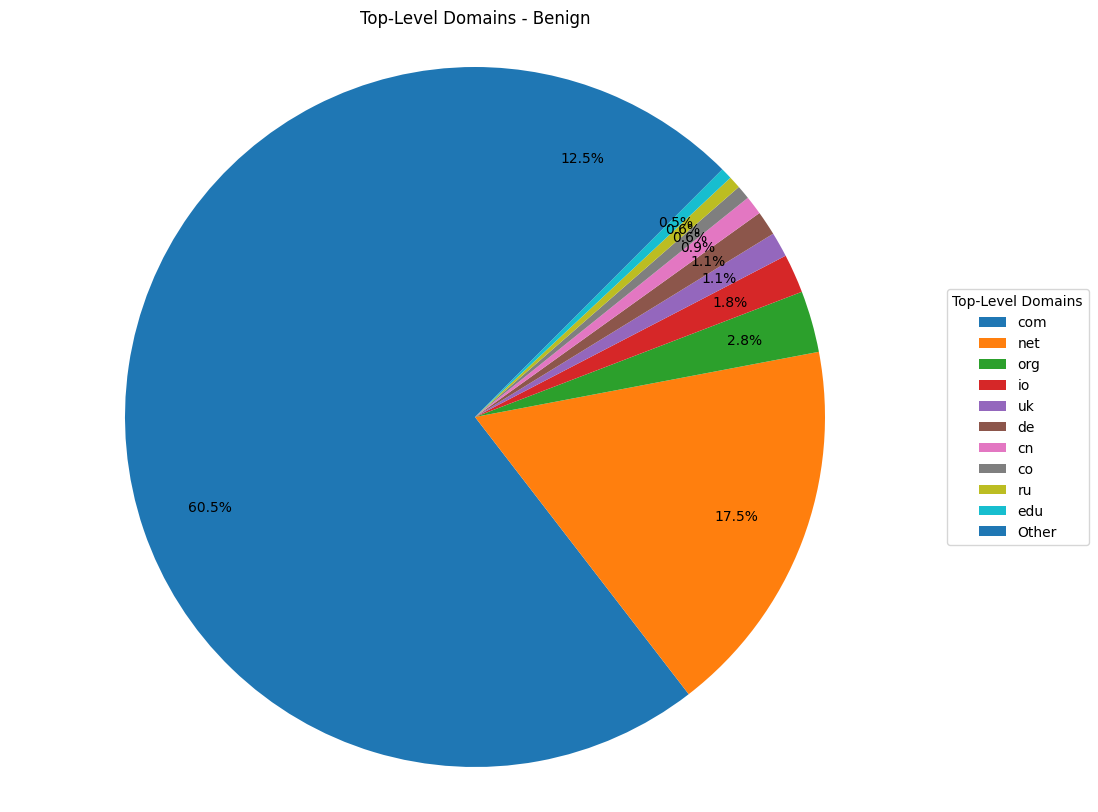

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_11416\3969064512.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


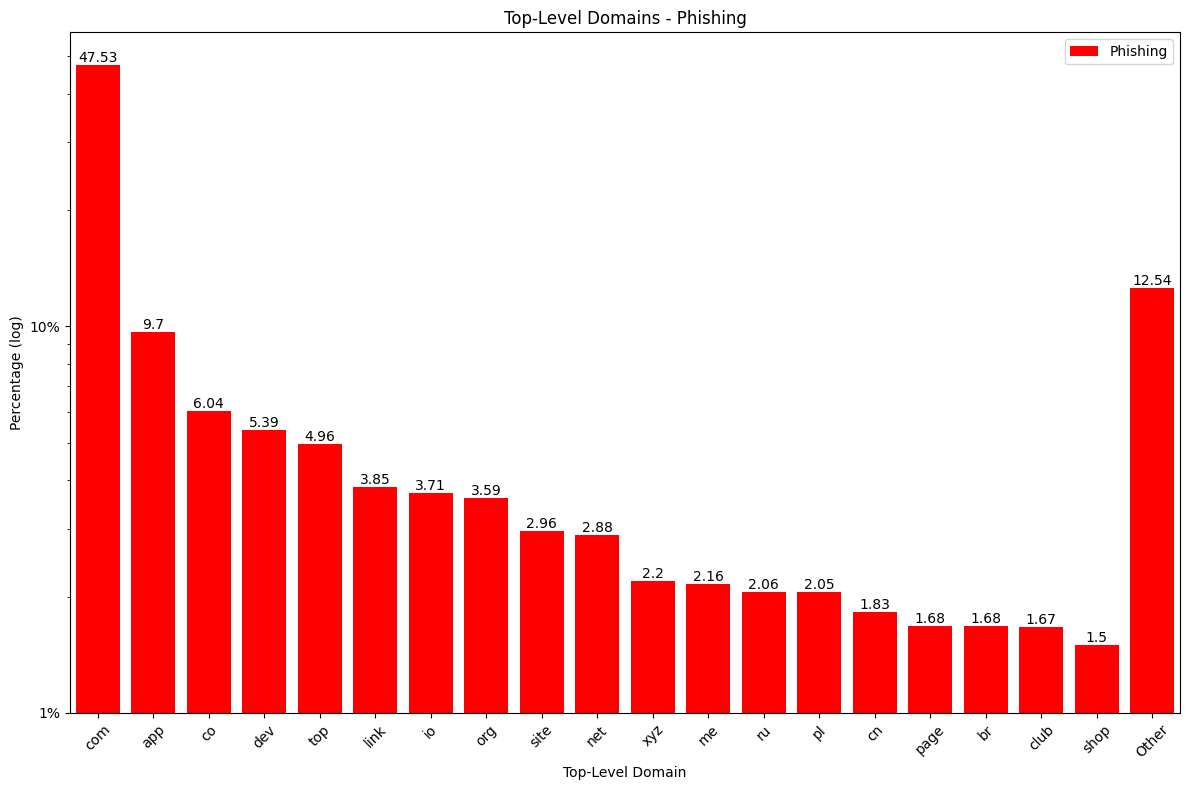

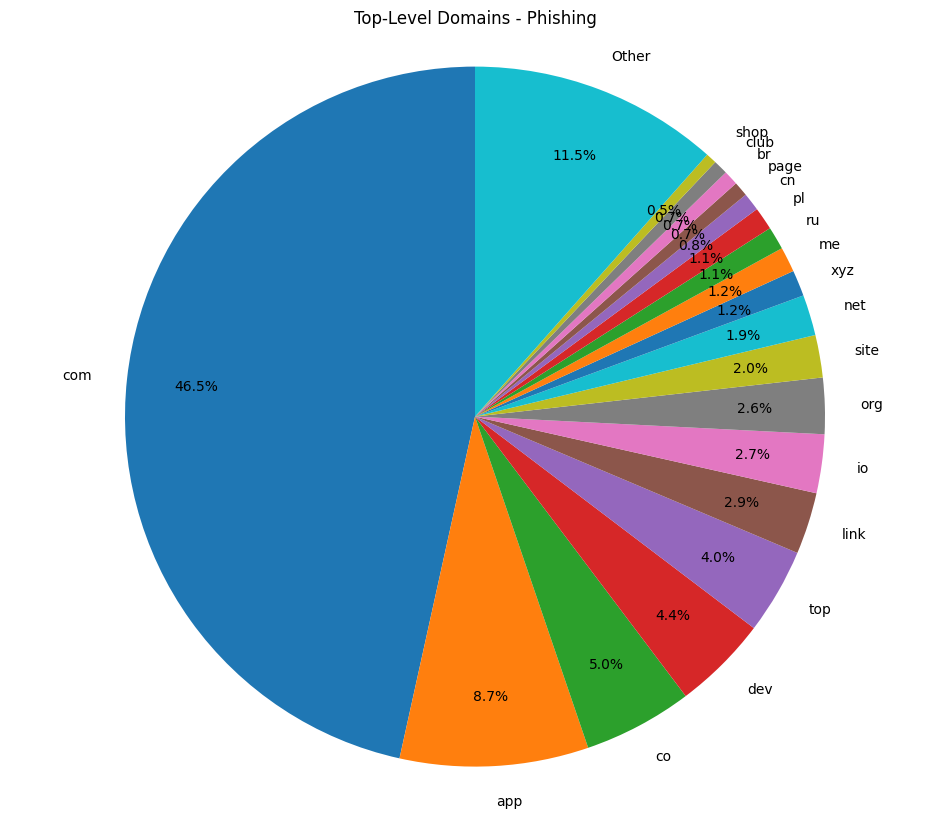

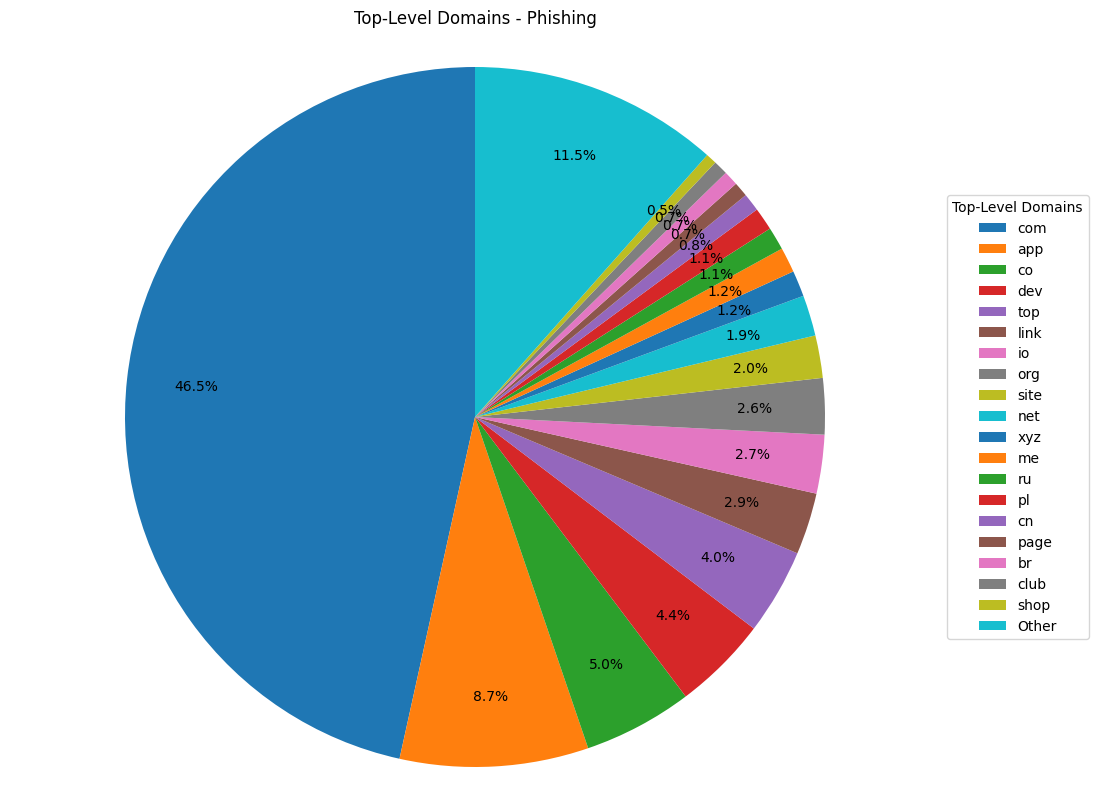

In [47]:
feature_name = "Top-Level Domain"

# Plot the Benign data
barplot_column_distribution(benign_tld_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
piechart_column_distribution(benign_tld_dist, feature_name, "Benign", color_map=plt.cm.Blues)
piechart_column_distribution(benign_tld_dist, feature_name, "Benign", color_map=plt.cm.Blues, legend=True)
# Plot the Phishing data
barplot_column_distribution(misp_tld_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
piechart_column_distribution(misp_tld_dist, feature_name, "Phishing")
piechart_column_distribution(misp_tld_dist, feature_name, "Phishing", legend=True)


### Lexical domain analysis (Averages)

#### Definitions

In [277]:
# Functions for domain characteristic calculations
def average_domain_length(domains):
    lengths = [len(domain) for domain in domains]
    return sum(lengths) / len(lengths)

def average_entropy(domains):
    def calculate_entropy(string):
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        return - sum([p * math.log(p) / math.log(2.0) for p in prob])

    entropies = [calculate_entropy(domain) for domain in domains]
    return sum(entropies) / len(entropies)

def average_char_groups(domains):
    letter_count = 0
    number_count = 0
    hex_count = 0
    other_count = 0

    for domain in domains:
        for char in domain:
            if char.isalpha():
                letter_count += 1
                if char in ['a', 'b', 'c', 'd', 'e', 'f', 'A', 'B', 'C', 'D', 'E', 'F']:
                    hex_count += 1
            elif char.isdigit():
                number_count += 1
                hex_count += 1
            else:
                other_count += 1

    total_chars = letter_count + number_count + other_count
    return {
        'letters': letter_count / total_chars,
        'numbers': number_count / total_chars,
        'hex': hex_count / total_chars,
        'other': other_count / total_chars
    }

def average_shortest_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    shortest_parts = [min(parts, key=len) for parts in domain_parts]
    return sum(len(part) for part in shortest_parts) / len(shortest_parts)


def average_longest_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    longest_parts = [max(parts, key=len) for parts in domain_parts]
    return sum(len(part) for part in longest_parts) / len(longest_parts)


def average_average_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    avg_lengths = [sum(len(part) for part in parts) / len(parts) if parts else 0 for parts in domain_parts]
    return sum(avg_lengths) / len(avg_lengths) if avg_lengths else 0


def average_subdomains_count(domains):
    subdomain_count = [domain.count('.') for domain in domains]
    return sum(subdomain_count) / len(subdomain_count)


#### Compute the values

In [278]:
# Fetching domain data from MongoDB collections
print("Fetching data from MongoDB collections...")
benign_domains = [entry['domain_name'] for entry in benign.find({}, {'domain_name': 1})]
misp_domains = [entry['domain_name'] for entry in misp.find({}, {'domain_name': 1})]

# Calculate domain characteristics
print("Calculating domain characteristics...")


benign_char_groups = average_char_groups(benign_domains)
benign_characteristics = {
    'AVG Length': average_domain_length(benign_domains),
    'AVG Entropy': average_entropy(benign_domains),
    'Letters Appearance': benign_char_groups["letters"],
    'Numbers Appearance': benign_char_groups["numbers"],
    'Hex Appearance': benign_char_groups["hex"],
    'Other Appearance': benign_char_groups["other"],
    'AVG Shortest Part Len': average_shortest_part_length(benign_domains),
    'AVG Longest Part Len': average_longest_part_length(benign_domains),
    'AVG Average Part Len': average_average_part_length(benign_domains),
    'AVG Subdomain Count': average_subdomains_count(benign_domains)
}

misp_char_groups = average_char_groups(misp_domains)
misp_characteristics = {
    'AVG Length': average_domain_length(misp_domains),
    'AVG Entropy': average_entropy(misp_domains),
    'Letters Appearance': misp_char_groups["letters"],
    'Numbers Appearance': misp_char_groups["numbers"],
    'Hex Appearance': misp_char_groups["hex"],
    'Other Appearance': misp_char_groups["other"],
    'AVG Shortest Part Len': average_shortest_part_length(misp_domains),
    'AVG Longest Part Len': average_longest_part_length(misp_domains),
    'AVG Average Part Len': average_average_part_length(misp_domains),
    'AVG Subdomain Count': average_subdomains_count(misp_domains)
}

# Print domain characteristics for each collection
print("\nBenign Characteristics:")
for key, value in benign_characteristics.items():
    print(f"{key}: {round(value, 5)}")
print("\nMISP Characteristics:")
for key, value in misp_characteristics.items():
    print(f"{key}: {round(value, 5)}")


Fetching data from MongoDB collections...
Calculating domain characteristics...

Benign Characteristics:
AVG Length: 22.24783
AVG Entropy: 3.53636
Letters Appearance: 0.81972
Numbers Appearance: 0.0516
Hex Appearance: 0.31798
Other Appearance: 0.12867
AVG Shortest Part Len: 2.71471
AVG Longest Part Len: 10.65587
AVG Average Part Len: 6.12801
AVG Subdomain Count: 2.26015

MISP Characteristics:
AVG Length: 26.90766
AVG Entropy: 3.75263
Letters Appearance: 0.79786
Numbers Appearance: 0.09516
Hex Appearance: 0.36882
Other Appearance: 0.10698
AVG Shortest Part Len: 2.82278
AVG Longest Part Len: 14.99622
AVG Average Part Len: 8.04693
AVG Subdomain Count: 2.10532


#### Plot the results

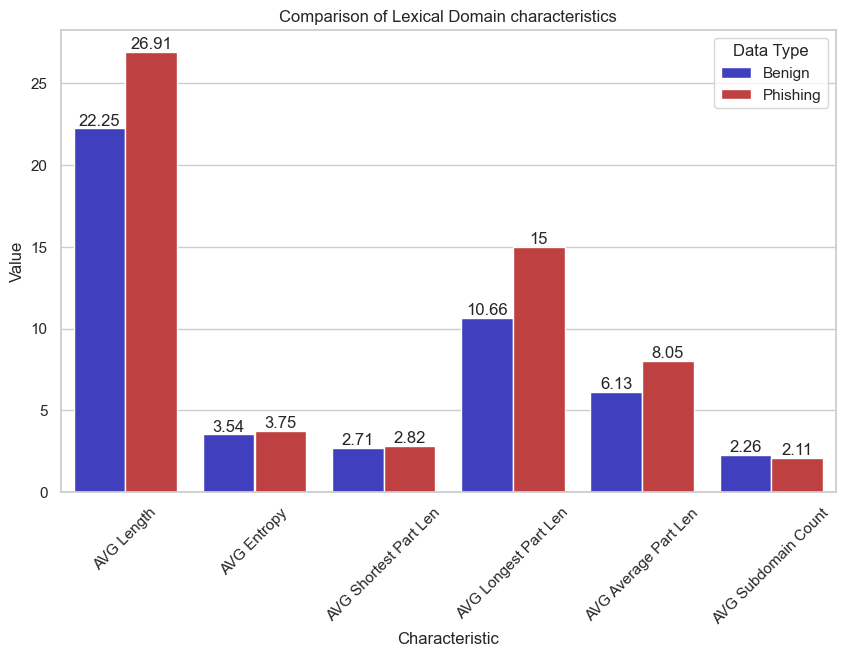

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_15804\1081543035.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


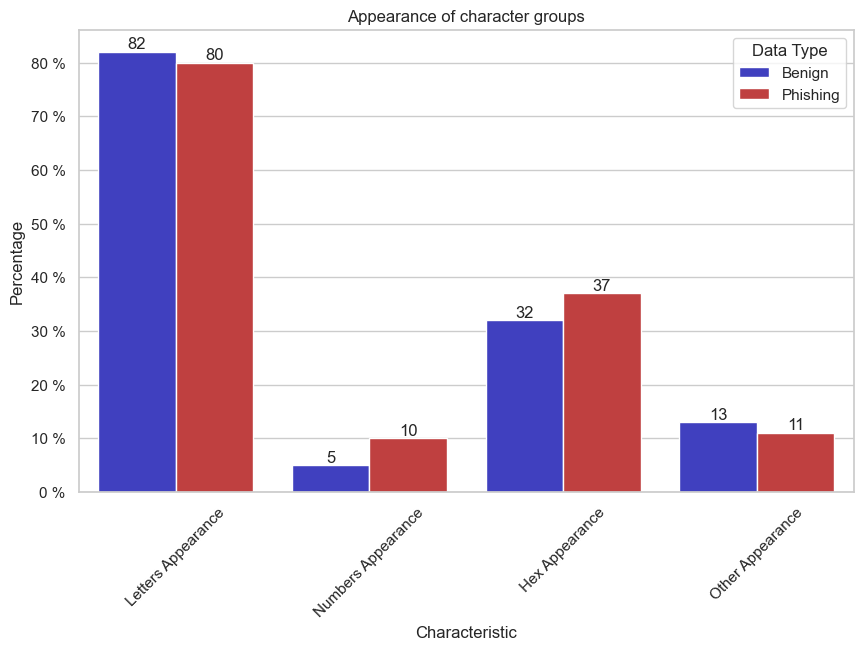

In [283]:
# Visualize the comparison
data_avg = {
    'Characteristic': [],
    'Benign': [],
    'Phishing': []
}

data_appearance = {
    'Characteristic': [],
    'Benign': [],
    'Phishing': []
}

for characteristic in benign_characteristics:
    data = data_avg if "AVG" in characteristic else data_appearance
    data['Characteristic'].append(characteristic)
    data['Benign'].append(round(benign_characteristics[characteristic], 2))
    data['Phishing'].append(round(misp_characteristics[characteristic], 2))

for data, percentages, title in (
    (data_avg, False, "Comparison of Lexical Domain characteristics"), 
    (data_appearance, True, "Appearance of character groups")
):
    # Convert to DataFrame
    df = pd.DataFrame(data)

    if percentages:
        df['Benign'] = df['Benign'] * 100
        df['Phishing'] = df['Phishing'] * 100
    
    # Melt the DataFrame for better visualization
    df_melted = df.melt('Characteristic', var_name='Data Type', value_name='Value')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Characteristic', y='Value', hue='Data Type', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.title(title)
    plt.xticks(rotation=45)

    if percentages:
        plt.ylabel('Percentage')
        yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
        ax.set_yticklabels(yticks_labels)

    plt.savefig(f"{image_path}/{title}_barplot.png")
    plt.show()

### Lexical domain analysis (Bigrams, Trigrams)

#### Init & definitions

In [97]:
from nltk import ngrams
import nltk
nltk.download('punkt') #   <----- RUN ONLY ONCE

[nltk_data] Downloading package punkt to C:\Users\Tomas
[nltk_data]     Foltyn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
def get_ngrams(domains, n):
    all_ngrams = []
    for domain in domains:
        tokens = nltk.word_tokenize(domain)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return all_ngrams

#### Compute and Plot the values

In [121]:
# Get bigrams and trigrams from the domain names
benign_bigrams = get_ngrams(benign_domains, 2)
misp_bigrams = get_ngrams(misp_domains, 2)

benign_trigrams = get_ngrams(benign_domains, 3)
misp_trigrams = get_ngrams(misp_domains, 3)

Top 10 Benign Bigrams: [(('rr1', '--'), 1648), (('rr2', '--'), 1600), (('rr3', '--'), 1328), (('rr4', '--'), 1159), (('rr5', '--'), 965), (('r1', '--'), 643), (('r2', '--'), 622), (('r3', '--'), 610), (('r4', '--'), 609), (('r5', '--'), 604)]
Top 10 MISP Bigrams: [(('xn', '--'), 63), (('1', '--'), 6), (('www', '--'), 6), (('--', 'wellsfargo'), 6), (('wellsfargo', '--'), 6), (('--', 'com'), 6), (('com', '--'), 6), (('--', 'smssssmsss.repl.co'), 5), (('--', 'promeriy.repl.co'), 4), (('--', 'p1ai'), 4)]
Top 10 Benign Trigrams: [(('--', '9hb.xn', '--'), 6), (('--', '9hbkg.xn', '--'), 6), (('--', 'production', '--'), 6), (('9hbkg.xn', '--', '9hb.xn'), 4), (('9hb.xn', '--', '9hb'), 3), (('xn', '--', '9hbcu.xn'), 3), (('--', '9hbcu.xn', '--'), 3), (('9hbcu.xn', '--', '9hbkg.xn'), 3), (('xn', '--', '9hbkg.xn'), 3), (('--', '8hb.xn', '--'), 3)]
Top 10 MISP Trigrams: [(('www', '--', 'wellsfargo'), 6), (('--', 'wellsfargo', '--'), 6), (('wellsfargo', '--', 'com'), 6), (('--', 'com', '--'), 6), ((

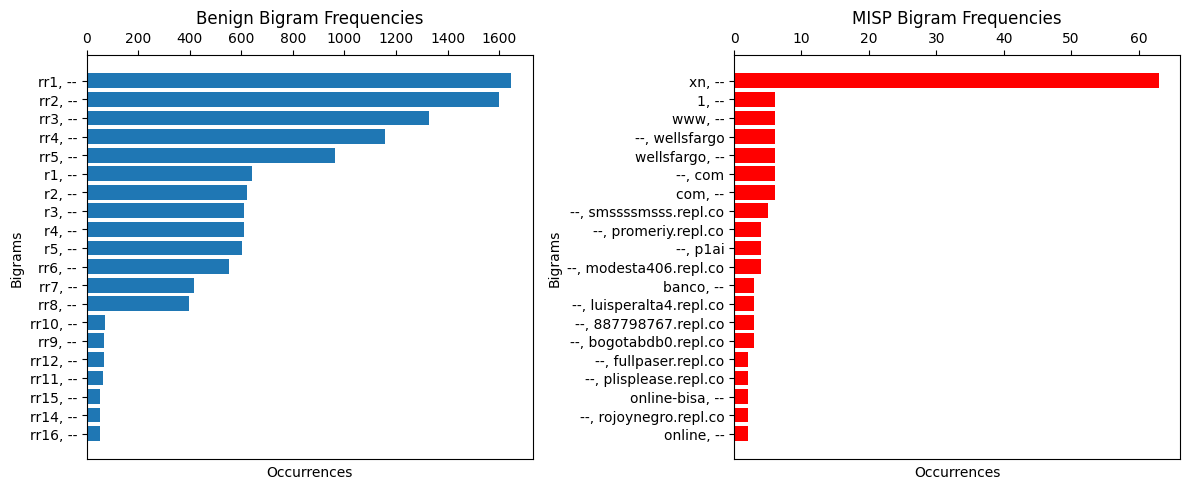

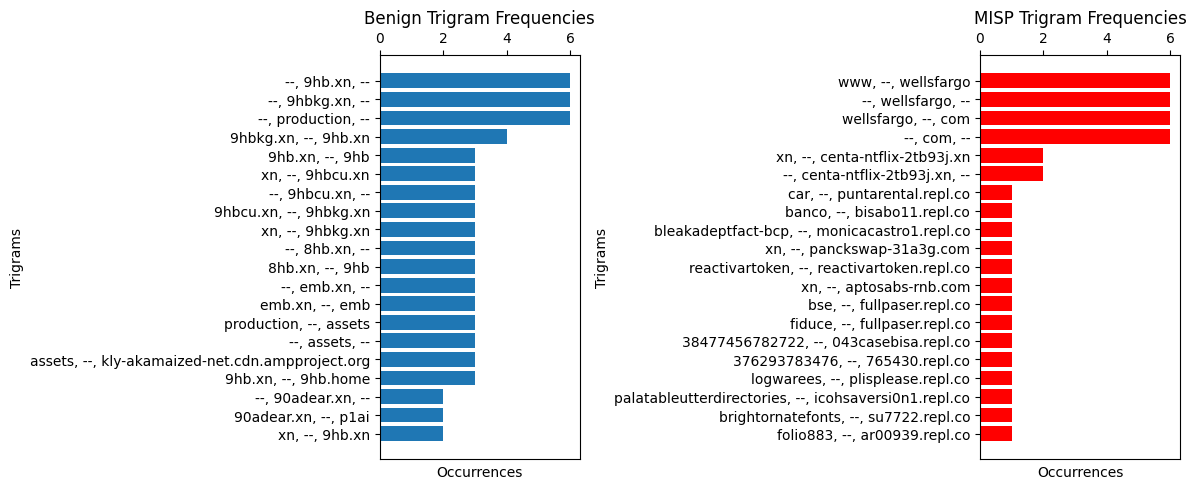

In [193]:
def plot_top_n_n_grams(benign_n_grams, misp_n_grams, top_n=20, ylabel=""):
    # Sort the bigrams by least common for both datasets
    counter_benign_bigrams = Counter(benign_n_grams).most_common(top_n)
    counter_misp_bigrams = Counter(misp_n_grams).most_common(top_n)
    
    total_benign_top_n = sum(count for _, count in counter_benign_bigrams)
    total_misp_top_n = sum(count for _, count in counter_misp_bigrams)
    
    total_benign_counts = len(benign_bigrams)
    total_misp_counts = len(misp_bigrams)
    
    # Extract bigram labels and counts for plotting
    benign_labels, benign_counts = zip(
        *reversed(counter_benign_bigrams)
    )
    misp_labels, misp_counts = zip(
        *reversed(counter_misp_bigrams)
    )
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.barh([", ".join(x) for x in benign_labels], benign_counts)
    plt.title(f'Benign {ylabel} Frequencies')
    plt.ylabel(ylabel+'s')
    plt.xlabel('Occurrences')
    plt.gca().xaxis.tick_top()
    
    plt.subplot(1, 2, 2)
    plt.barh([", ".join(x) for x in misp_labels], misp_counts, color="r")
    plt.title(f'MISP {ylabel} Frequencies')
    plt.ylabel(ylabel+'s')
    plt.xlabel('Occurrences')
    plt.gca().xaxis.tick_top()
    
    plt.tight_layout()
    plt.show()


plot_top_n_n_grams(benign_bigrams, misp_bigrams, ylabel="Bigram")
plot_top_n_n_grams(benign_trigrams, misp_trigrams, ylabel="Trigram")


## IP

### Data init

#### Definitions (run all)

In [16]:
set_iamge_subpath("ip")

# WARNING! FUNCTION EXECUTES CODE!!!! 
# ONLY USE ON CSV FILES YOU KNOW ARE SAFE
def load_csv_dumped_column(x):
    if type(x) is list or type(x) is str:
        # because of the datetime, literal_eval throws an error 
        return eval(x)
    return None

def prepare_column_data(df, column):
    # Explode the ip_data column
    df["og_id"] = df["_id"]
    df = df.explode(column)
    df = df.dropna(subset=[column])

    # Flatten the column
    flattened = pd.json_normalize(df[column])
    flattened.reset_index(drop=True, inplace=True)
    
    # Create new IDs
    new_ids = range(len(flattened))
    
    # Map new IDs to original IDs
    id_mapping = dict(zip(new_ids, df["og_id"]))
    flattened["_id"] = flattened.index.map(id_mapping)

    # Join the flattened column with the original DataFrame
    df = df.join(flattened, rsuffix='_flattened')

    return df

In [4]:
# run to save ip loaded and processed datasets
def save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips):
    benign_ips.to_csv('analysis_data/mongo/benign_ips.csv', index=False)
    misp_ips.to_csv('analysis_data/mongo/misp_ips.csv', index=False)
    w_misp_ips.to_csv('analysis_data/mongo/w_misp_ips.csv', index=False)
    w_benign_ips.to_csv('analysis_data/mongo/w_benign_ips.csv', index=False)

# run to load ip datasets (if there are any)
def load_ip_data():
    benign_ips = pd.read_csv('analysis_data/mongo/benign_ips.csv')
    misp_ips = pd.read_csv('analysis_data/mongo/misp_ips.csv')
    w_misp_ips = pd.read_csv('analysis_data/mongo/w_misp_ips.csv')
    w_benign_ips = pd.read_csv('analysis_data/mongo/w_benign_ips.csv')
    return benign_ips, misp_ips, w_benign_ips, w_misp_ips

#### Load cashed data from `/analysis_data/mongo/` (if there are any)

In [29]:
save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)
# benign_ips, misp_ips, w_benign_ips, w_misp_ips = load_ip_data()

#### Load and prepare data (if not loaded already in previous block)

Load IP data from MongoDB into DataFrames. **takes a long time**

In [5]:
# Fetch the first 50,000 entries from benign and misp DataFrames
benign_ips = pd.DataFrame(list(benign.find({}, {"ip_data": 1}).limit(100_000)))
misp_ips = pd.DataFrame(list(misp.find({}, {"ip_data": 1})))

sample a percentage of the datasets to use for development (so test runs don't take ages)

In [6]:
w_benign_ips = benign_ips.sample(frac=1)
w_misp_ips = misp_ips.sample(frac=1)

transrom the csv strings in 'ip_data' column into python literals. **NOT NEEDED, IF LOADED DIRECTLY FROM DB** 

In [17]:
w_benign_ips['ip_data'] = w_benign_ips['ip_data'].apply(load_csv_dumped_column)
w_misp_ips['ip_data'] = w_misp_ips['ip_data'].apply(load_csv_dumped_column)

TypeError: eval() arg 1 must be a string, bytes or code object

parse and shape the data into suitable form

In [7]:
w_benign_ips = prepare_column_data(w_benign_ips, "ip_data")
w_misp_ips = prepare_column_data(w_misp_ips, "ip_data")

# at this point it would be suitable to call save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)

#### Print out some samples

In [66]:
print(w_misp_ips.columns)
print(w_misp_ips['ip_data'].iloc[1])

Index(['_id', 'ip_data', 'og_id', 'ip', 'from_record', 'rep', 'ports',
       'remarks.rdap_evaluated_on', 'remarks.asn_evaluated_on',
       'remarks.geo_evaluated_on', 'remarks.rep_evaluated_on',
       'remarks.icmp_evaluated_on', 'remarks.is_alive', 'remarks.average_rtt',
       'remarks.ports_scanned_on', 'rdap.handle', 'rdap.parent_handle',
       'rdap.name', 'rdap.whois_server', 'rdap.type',
       'rdap.terms_of_service_url', 'rdap.copyright_notice',
       'rdap.description', 'rdap.last_changed_date', 'rdap.registration_date',
       'rdap.expiration_date', 'rdap.url', 'rdap.rir',
       'rdap.entities.registrant', 'rdap.entities.routing',
       'rdap.entities.abuse', 'rdap.entities.technical', 'rdap.entities.noc',
       'rdap.entities.administrative', 'rdap.country', 'rdap.ip_version',
       'rdap.assignment_type', 'rdap.network.prefix_length',
       'rdap.network.network_address', 'rdap.network.netmask',
       'rdap.network.broadcast_address', 'rdap.network.hostmask', 

### Analyse IPv4 percentage

#### Definitions

In [8]:
def average_ipv_percentage(source_df, version):
    df = source_df.copy()
    df.dropna(subset=["rdap.ip_version"])
    # Count the occurrences of IPv4 and IPv6 for each ID
    ipv4_ipv6_counts = df.groupby("_id_flattened")["rdap.ip_version"].value_counts().unstack(fill_value=0)

    # Calculate the percentage of IPv4 among the IDs
    ipv4_ipv6_counts["ipv4_percentage"] = (ipv4_ipv6_counts[version] / (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6]))
    # fillter only IDs, that have total number of IPs > 0
    ipv4_ipv6_mask = (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6]) > 0
    # apply filter
    ipv4_ipv6_counts = ipv4_ipv6_counts[ipv4_ipv6_mask]
    ipv4_ipv6_counts["ipv4_percentage"].dropna()

    return ipv4_ipv6_counts["ipv4_percentage"]

def distribution_on_n_bins(df, n=10):
    # split into n bins
    bins = pd.cut(df, bins=n, labels=[round(x/n-1, 1) for x in range(n)])
    # get the count in each bin
    bins_counts = bins.value_counts().sort_index()
    # normalize
    return bins_counts / bins_counts.sum()


def dataset_ipv_percentage(source_df, version):
    df = source_df.copy()
    df.dropna(subset="rdap.ip_version")
    # Count the occurrences of IPv4 and IPv6
    ipv4_ipv6_counts = df["rdap.ip_version"].value_counts()
    return ipv4_ipv6_counts[version] / (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6])

def n_bin_percentage_scale(n):
    return [f"{round((x/n)*100)}-{round(((x+1)/n)*100)}%" for x in range(n)]

#### Calculate the values

In [9]:
# Calculate values
n_bins = 10

w_benign_ips_avg_ipv4 = average_ipv_percentage(w_benign_ips, 4)
w_benign_ipv4_dist = distribution_on_n_bins(w_benign_ips_avg_ipv4, n_bins)
w_misp_ips_avg_ipv4 = average_ipv_percentage(w_misp_ips, 4)
w_misp_ipv4_dist = distribution_on_n_bins(w_misp_ips_avg_ipv4, n_bins)
dataset_ipv4_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, 4), 3)
dataset_ipv4_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, 4), 3)

w_benign_ips_avg_ipv6 = average_ipv_percentage(w_benign_ips, 6)
w_misp_ips_avg_ipv6 = average_ipv_percentage(w_misp_ips, 6)
dataset_ipv6_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, 6), 3)
dataset_ipv6_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, 6), 3)


#### Plot the results

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_2564\2168360256.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)
C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_2564\2168360256.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(yticks_labels)


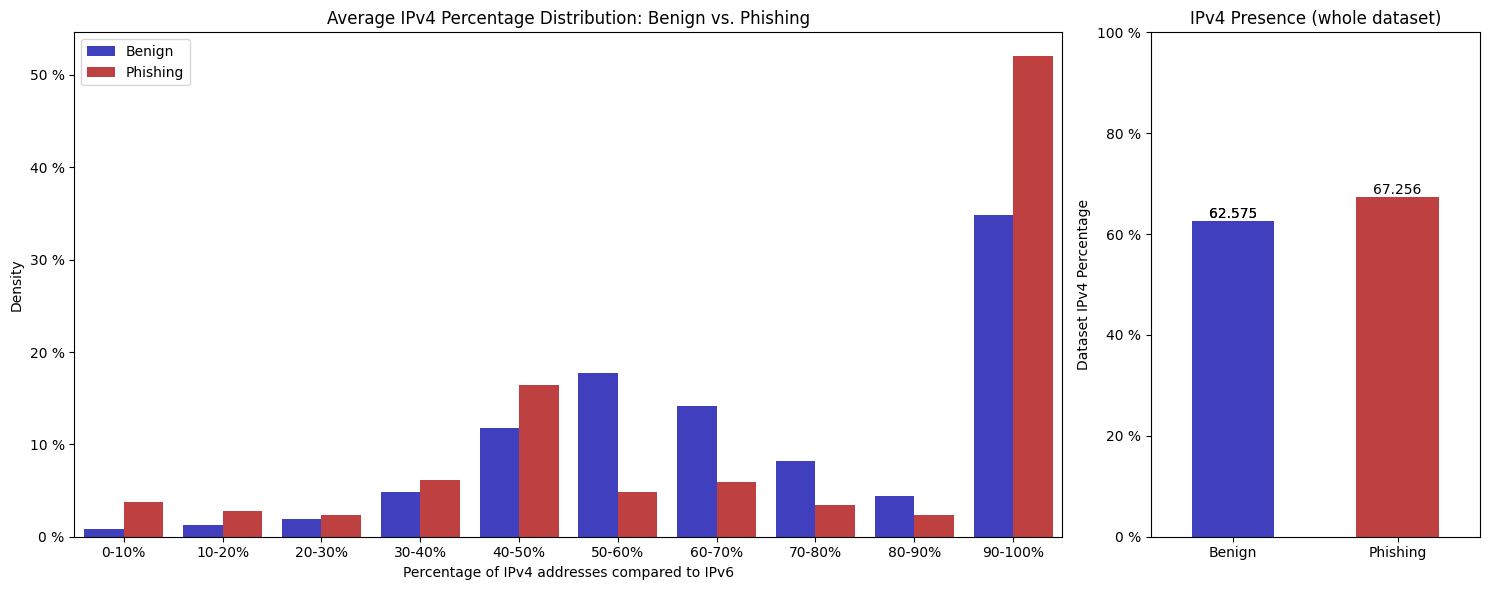

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_2564\2168360256.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)
C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_2564\2168360256.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(yticks_labels)


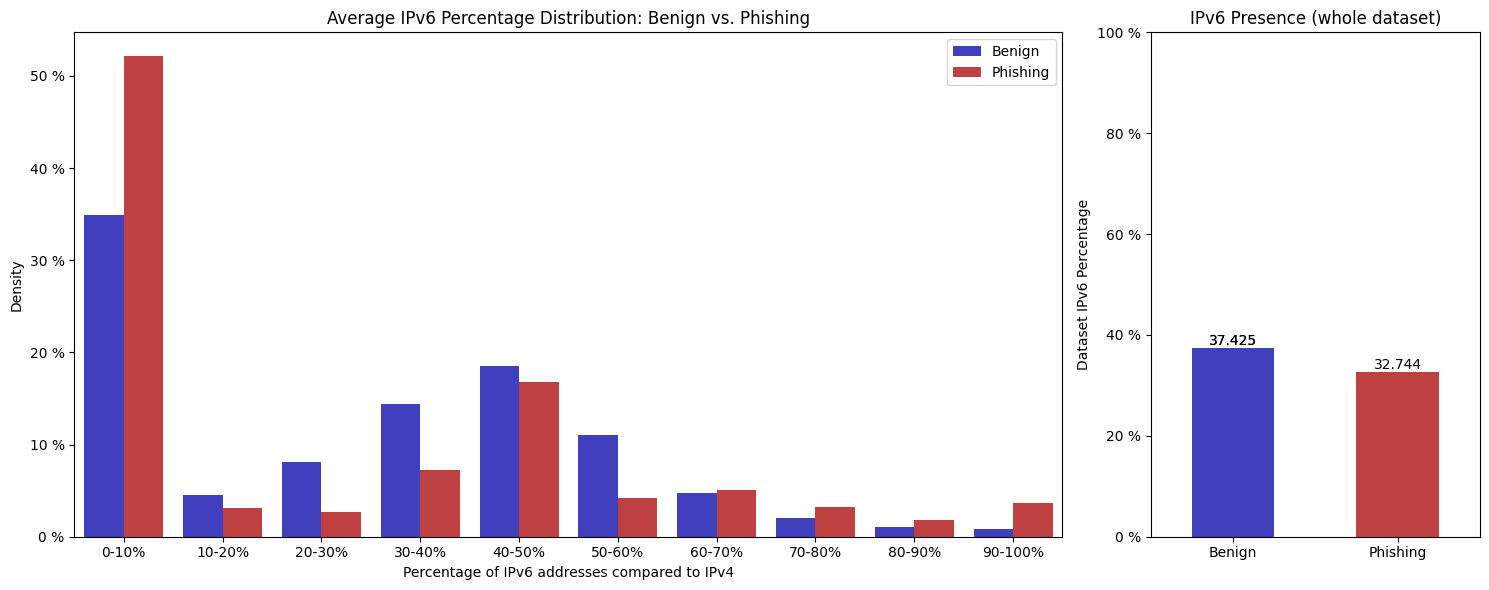

In [17]:
# Create a figure with two subplots
def plot_ipv_n_distribution(n, w_benign_dist, w_misp_dist, dataset_percentage_benign, dataset_percentage_misp):
    other_n = 10 - n
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    df = pd.DataFrame(data={
        "index": n_bin_percentage_scale(n_bins),
        "Benign": w_benign_dist * 100,
        "Phishing": w_misp_dist * 100
    })
    df_melted = df.melt('index', var_name='Data Type', value_name='Value')
    
    # Plotting

    # for some reason, log)scale doesn't work here
    ax = sns.barplot(x='index', y='Value', hue='Data Type', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5, ax=axes[0])
    axes[0].set_xlabel(f'Percentage of IPv{n} addresses compared to IPv{other_n}')
    axes[0].set_ylabel('Density')
    yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
    ax.set_yticklabels(yticks_labels)
    axes[0].set_title(f'Average IPv{n} Percentage Distribution: Benign vs. Phishing')
    axes[0].legend()
    
    
    # Create a narrow tall plot to the right
    bars = sns.barplot(x=['Benign', 'Phishing'], y=[dataset_percentage_benign, dataset_percentage_misp], hue=['Benign', 'Phishing'], ax=axes[1], palette=['b', 'r'], saturation=0.5, dodge=False, width=0.5)

    
    axes[1].set_ylabel(f'Dataset IPv{n} Percentage')
    # axes[1].set_xlabel('')
    axes[1].set_title(f'IPv{n} Presence (whole dataset)')
    axes[1].set_ylim(0, 100)
    yticks_labels = [label.get_text() + " %" for label in axes[1].get_yticklabels()]
    axes[1].set_yticklabels(yticks_labels)
    axes[1].bar_label(axes[1].containers[0], fontsize=10);
    
    # Add labels to both bars
    for container, label in zip(axes[1].containers, ['Benign', 'Phishing']):
        axes[1].bar_label(container, label=label, fontsize=10)
    
    plt.tight_layout()
    fig.savefig(f"{image_path}/Average IPv{n} Percentage Distribution_barplot.png")
    fig.savefig(f"{image_path}/Average IPv{n} Percentage Distribution_barplot.pdf", format="pdf")
    plt.show()


for n in [4, 6]:
    # calculate the average percentage of IPv{n} addresses in benign and misp
    w_benign_ips_avg = average_ipv_percentage(w_benign_ips, n)
    w_misp_ips_avg = average_ipv_percentage(w_misp_ips, n)
    # calculate the distributions
    w_benign_dist = distribution_on_n_bins(w_benign_ips_avg, n_bins)
    w_misp_dist = distribution_on_n_bins(w_misp_ips_avg, n_bins)
    # calculate the percentage of IPv{n} addresses on whole benign and misp datasets
    dataset_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, n) * 100, 3)
    dataset_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, n) * 100, 3)
    # plot the result
    plot_ipv_n_distribution(n, w_benign_dist, w_misp_dist, dataset_percentage_benign, dataset_percentage_misp)



### Other IP features

In [ ]:
# Function to analyze RDAP entity types distribution for each IP
def rdap_entity_types_distribution(df):
    entity_types = ['administrative', 'registrant', 'registrar', 'abuse', 'admin', 'technical']
    rdap_entities_data = {entity_type: df[f'rdap_entities.{entity_type}'].apply(lambda x: len(x) if x else 0).sum() for entity_type in entity_types}
    return rdap_entities_data

In [ ]:
# Function to analyze the distribution of ASNs
def asn_distribution(df):
    asns = df["ip_data.asn.asn"].explode().value_counts()
    return asns

# Function to analyze the distribution of ISPs
def isp_distribution(df):
    isps = df["ip_data.geo.isp"].explode().value_counts()
    return isps

# Function to analyze DNS record types distribution for each IP
def dns_record_types_distribution(df):
    dns_types = ['dns_A', 'dns_AAAA', 'dns_CNAME', 'dns_MX', 'dns_NS', 'dns_SOA', 'dns_TXT']
    dns_data = {dns_type: df[dns_type].apply(lambda x: len(x) if x else 0).sum() for dns_type in dns_types}
    return dns_data

# Function to analyze TLS protocols distribution for each IP
def tls_protocol_distribution(df):
    tls_protocols = df["tls.protocol"].explode().value_counts()
    return tls_protocols

# Function to analyze RDAP entity types distribution for each IP
def rdap_entity_types_distribution(df):
    entity_types = ['administrative', 'registrant', 'registrar', 'abuse', 'admin', 'technical']
    rdap_entities_data = {entity_type: df[f'rdap_entities.{entity_type}'].apply(lambda x: len(x) if x else 0).sum() for entity_type in entity_types}
    return rdap_entities_data

## RDAP

#### Fetch data

In [20]:
set_iamge_subpath("rdap")

fields_to_fetch = [
    "rdap",
    "evaluated_on"
]
filed_dict = {key:1 for key in fields_to_fetch}
benign_rdap = pd.DataFrame(list(benign.find({}, filed_dict)))
misp_rdap = pd.DataFrame(list(misp.find({}, filed_dict)))

### Registrar name

#### Compute values

In [21]:
def get_registrar_names(df):
    df["registrar"] = df["rdap"].dropna().apply(lambda x: x.get("entities").get("registrar"))
    df["registrar"] = df["registrar"].dropna()

    [print(x) for x in df["registrar"] if type(x) is not list and type(x) is not float]
    flattened_registrars = [entry.get("name") for sublist in df["registrar"] if type(sublist) == list for entry in sublist if entry.get("name") and len(entry.get("name")) > 0]
    
    return pd.DataFrame(data={
        "registrar": flattened_registrars
    })

benign_reg_names = get_registrar_names(benign_rdap)
benign_reg_name_dist = calculate_column_distribution(benign_reg_names, "registrar", 0.01)
misp_reg_names = get_registrar_names(misp_rdap)
misp_reg_name_dist = calculate_column_distribution(misp_reg_names, "registrar", 0.01)

#### Plot the values

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\54542936.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  set_yticklabels(yticks_labels)


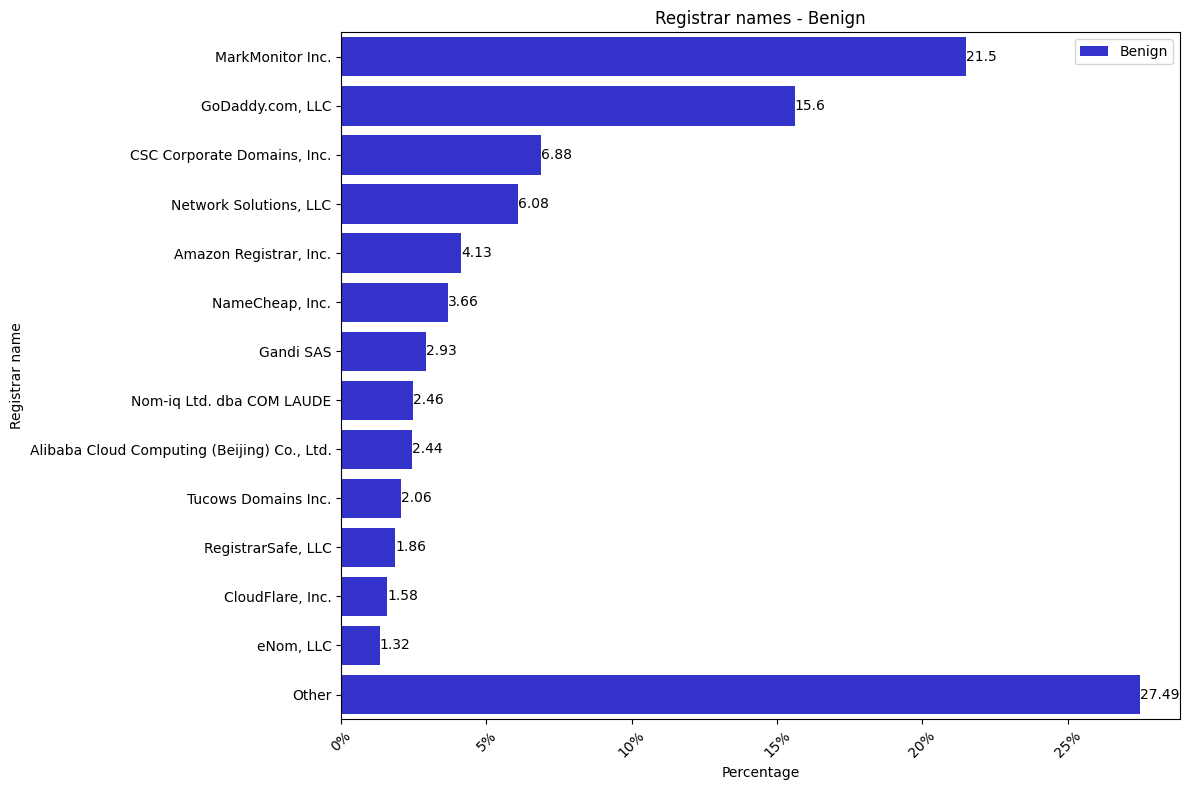

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\54542936.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  set_yticklabels(yticks_labels)


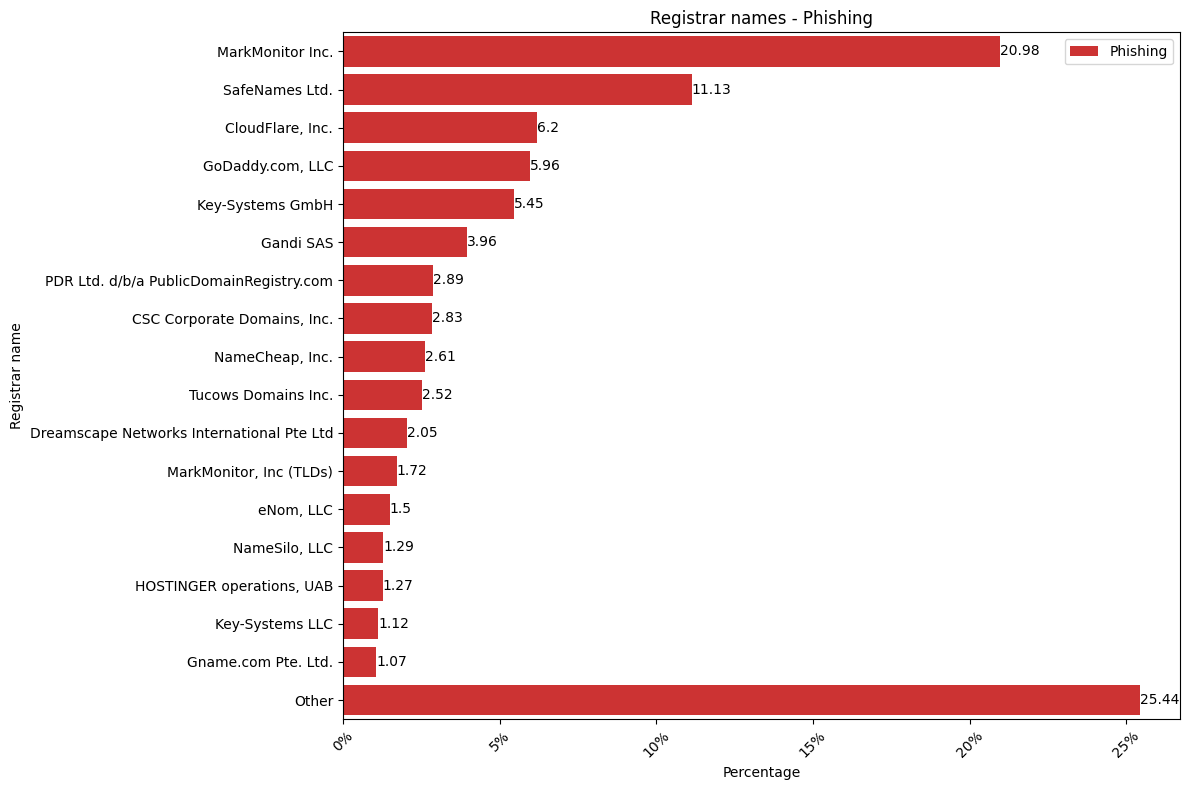

In [22]:
barplot_column_distribution(benign_reg_name_dist, "Registrar name", "Benign", color="b", orient="h")
barplot_column_distribution(misp_reg_name_dist, "Registrar name", "Phishing", color="r", orient="h")

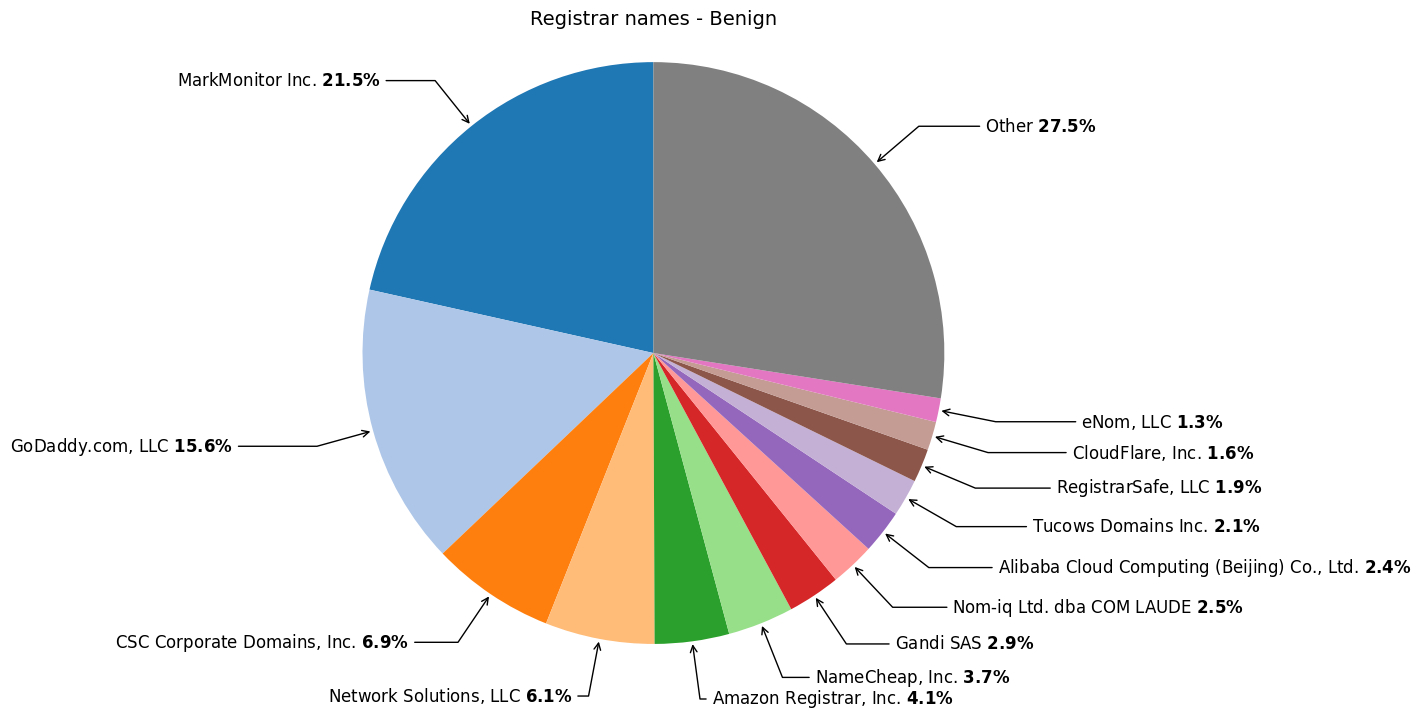

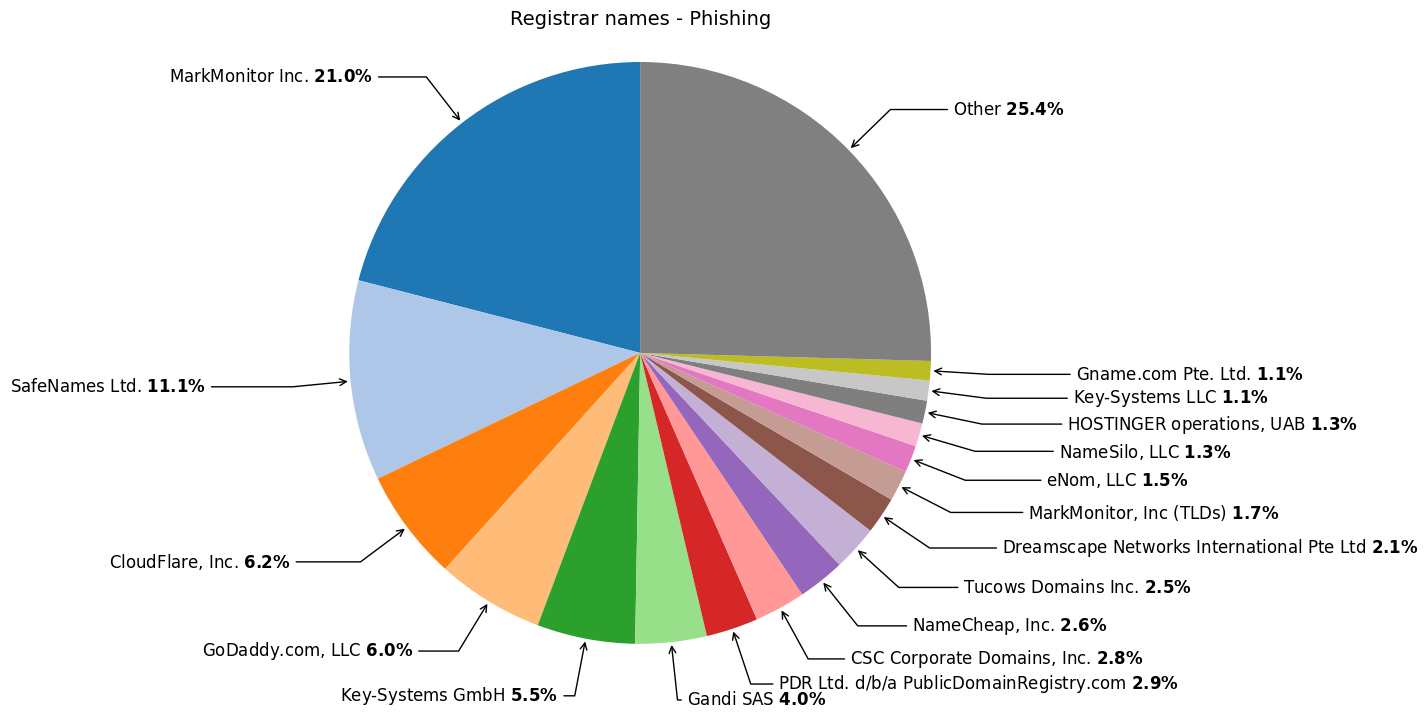

In [23]:
piechart_column_distribution3(benign_reg_name_dist, "Registrar name", "Benign")
piechart_column_distribution3(misp_reg_name_dist, "Registrar name", "Phishing")

### Entities

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\1005992036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Entities"] = benign_rdap["rdap"].dropna().apply(lambda x: x.get("entities"))
C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\1005992036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Entities"] = benign_rdap["rdap"].dropna().apply(lambda x: x.get("entities"))
C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\1005992036.py:45: UserWarning: set_ticklabels() sho

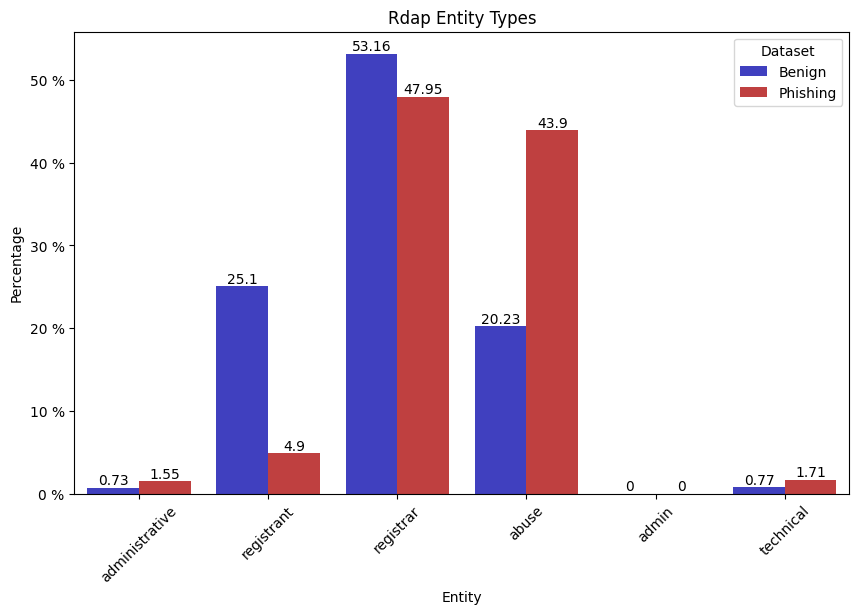

In [24]:
def count_non_empty_objects(entity_list):
    count = sum(1 for obj in entity_list if obj)
    return count

entity_counts = {
    'Entity': ["administrative", "registrant", "registrar", "abuse", "admin", "technical"],
    'Benign': [],
    'Phishing': []
}

# Compute entity counts for df1
for df, df_name in [(benign_rdap, "Benign"), (misp_rdap, "Phishing")]:
    # Filter out rows where "rdap" is None
    df = df[df["rdap"].notna()]

    df["Entities"] = benign_rdap["rdap"].dropna().apply(lambda x: x.get("entities"))

    df_entity_counts = {key: 0 for key in entity_counts["Entity"]}

    def add_counts(entities):
        if type(entities) == dict:
            for key, value in entities.items():
                if key in entity_counts["Entity"]:
                    df_entity_counts[key] += len([x for x in value if x.get("name") or x.get("email")])
    
    df["Entities"].apply(add_counts)
    
    counts = np.array(list(df_entity_counts.values()))
    normalized = counts / counts.sum()
    entity_counts[df_name] = [round(x * 100, 2) for x in normalized]


df_melted = pd.DataFrame(entity_counts).melt('Entity', var_name='Dataset', value_name='Value')
    
# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Entity', y='Value', hue='Dataset', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title("Rdap Entity Types")
plt.xticks(rotation=45)

plt.ylabel('Percentage')
yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
ax.set_yticklabels(yticks_labels)

plt.savefig(f"{image_path}/Rdap_Entity_Types_barplot.png")
plt.savefig(f"{image_path}/Rdap_Entity_Types_barplot.pdf", format="pdf")
plt.show()


### Domain age

In [25]:
benign_rdap["domain_age"] = benign_rdap["evaluated_on"] - benign_rdap["rdap"].dropna().apply(lambda x: x.get("registration_date"))

misp_rdap["domain_age"] = misp_rdap["evaluated_on"] - misp_rdap["rdap"].dropna().apply(lambda x: x.get("registration_date"))


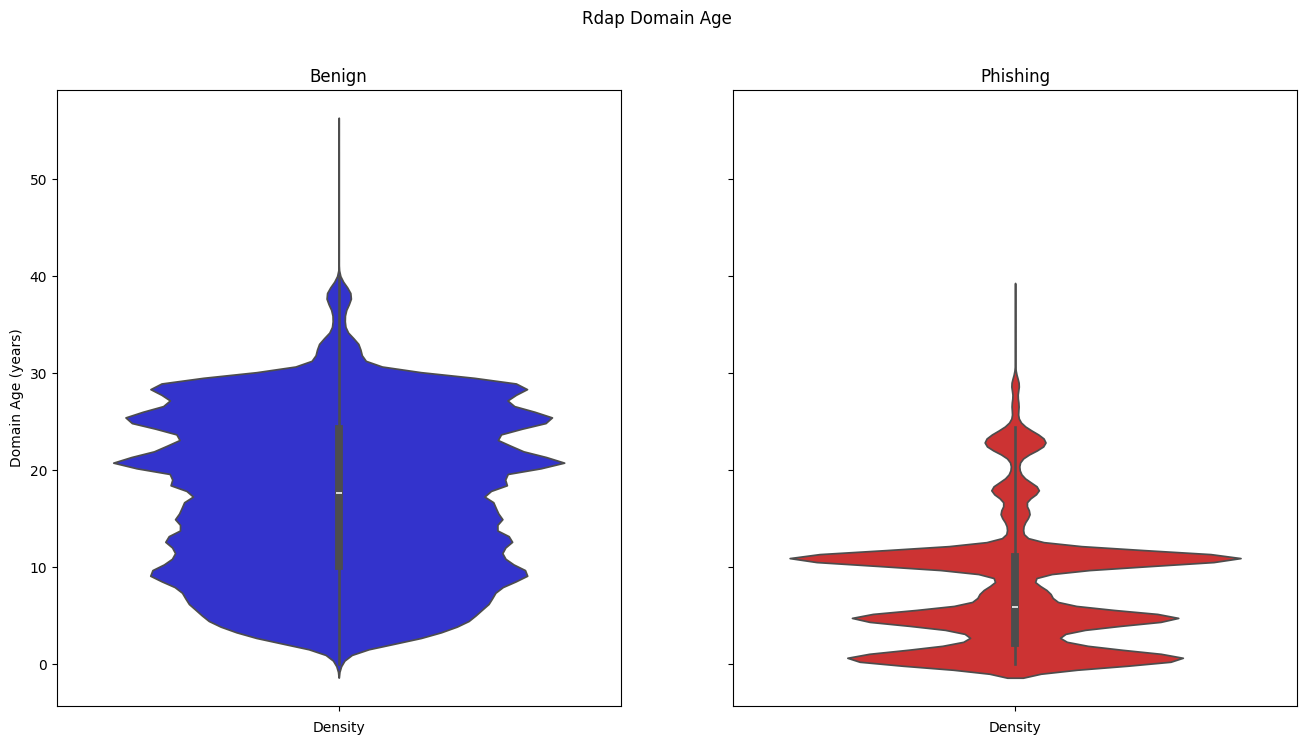

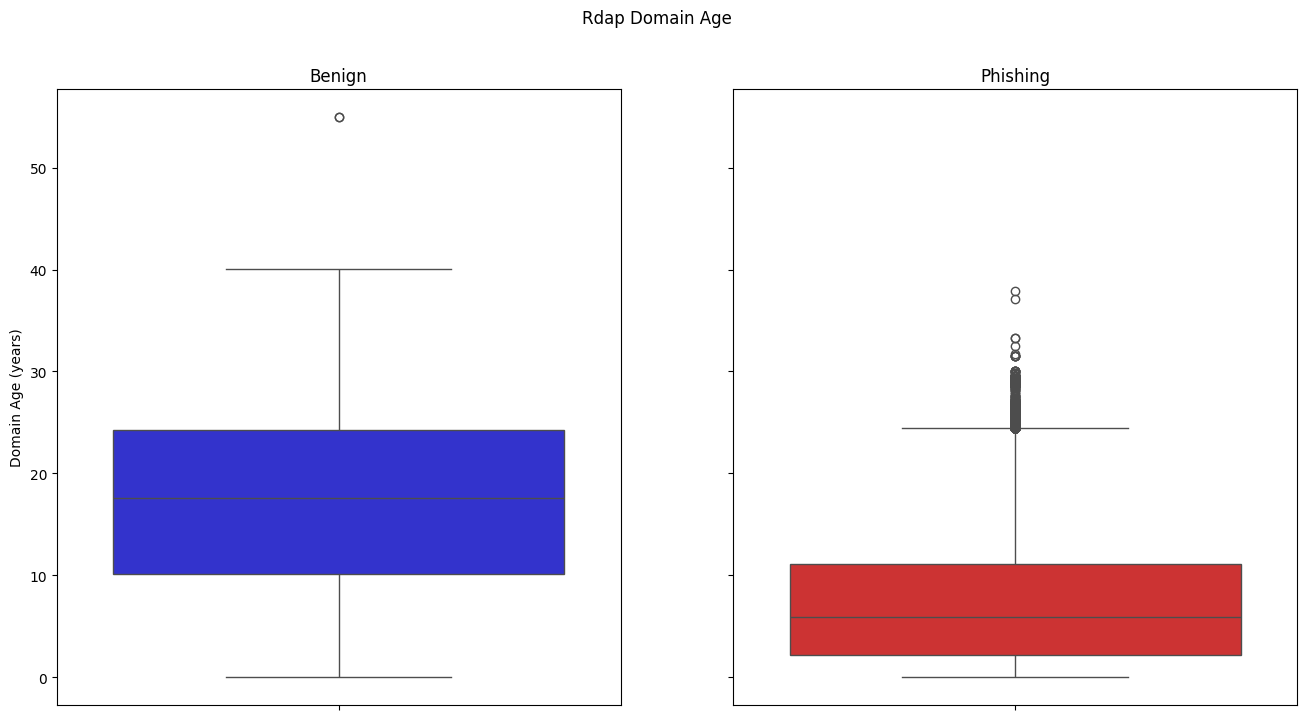

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df1 and df2 are your DataFrames
# Convert timedelta64[ns] to days
benign_rdap['domain_age_years'] = benign_rdap['domain_age'].dt.days / 356
misp_rdap['domain_age_years'] = misp_rdap['domain_age'].dt.days / 356

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot the first violin plot (horizontal)
sns.violinplot(y='domain_age_years', data=benign_rdap, color='blue', ax=axes[0], saturation=0.6)
axes[0].set_title('Benign')
axes[0].set_ylabel('Domain Age (years)')
axes[0].set_xlabel('Density')

# Plot the second violin plot (horizontal)
sns.violinplot(y='domain_age_years', data=misp_rdap, color='red', ax=axes[1], saturation=0.6)
axes[1].set_title('Phishing')
axes[1].set_ylabel('Domain Age (years)')
axes[1].set_xlabel('Density')

plt.suptitle('Rdap Domain Age', fontsize=12)

plt.savefig(f"{image_path}/Rdap_Domain_Age_violinplot.png")
plt.savefig(f"{image_path}/Rdap_Domain_Age_violinplot.pdf", format="pdf")
plt.show()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot the first violin plot (horizontal)
sns.boxplot(y='domain_age_years', data=benign_rdap, color='blue', ax=axes[0], saturation=0.6)
axes[0].set_title('Benign')
axes[0].set_ylabel('Domain Age (years)')

# Plot the second violin plot (horizontal)
sns.boxplot(y='domain_age_years', data=misp_rdap, color='red', ax=axes[1], saturation=0.6)
axes[1].set_title('Phishing')
axes[1].set_ylabel('Domain Age (years)')

plt.suptitle('Rdap Domain Age', fontsize=12)

plt.savefig(f"{image_path}/Rdap_Domain_Age_boxplot.png")
plt.savefig(f"{image_path}/Rdap_Domain_Age_boxplot.pdf", format="pdf")
plt.show()


## DNS 

### Fetch data

In [29]:
set_iamge_subpath("dns")

fields_to_fetch = [
    "dns",
]
filed_dict = {key:1 for key in fields_to_fetch}
benign_dns = pd.DataFrame(list(benign.find({}, filed_dict).limit(50_000)))
misp_dns = pd.DataFrame(list(misp.find({}, filed_dict)))

### tll_*

#### Compute values

In [30]:
from transformers.dns import make_ttl_features

benign_dns["ttls"] = benign_dns["dns"].dropna().apply(lambda x: x.get("ttls"))
benign_ttls = benign_dns.dropna(subset=['ttls'])

benign_ttls["dns_ttl_avg"], benign_ttls["dns_ttl_stdev"], benign_ttls["dns_ttl_low"], benign_ttls["dns_ttl_mid"], benign_ttls["dns_ttl_distinct_count"] = zip(
        *benign_ttls["ttls"].apply(make_ttl_features))


misp_dns["ttls"] = misp_dns["dns"].dropna().apply(lambda x: x.get("ttls"))
misp_ttls = misp_dns.dropna(subset=['ttls'])

misp_ttls["dns_ttl_avg"], misp_ttls["dns_ttl_stdev"], misp_ttls["dns_ttl_low"], misp_ttls["dns_ttl_mid"], misp_ttls["dns_ttl_distinct_count"] = zip(
        *misp_ttls["ttls"].apply(make_ttl_features))



C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\1434243350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benign_ttls["dns_ttl_avg"], benign_ttls["dns_ttl_stdev"], benign_ttls["dns_ttl_low"], benign_ttls["dns_ttl_mid"], benign_ttls["dns_ttl_distinct_count"] = zip(
C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\1434243350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benign_ttls["dns_ttl_avg"], benign_ttls["dns_ttl_stdev"], benign_ttls["dns_ttl_low"], benign_ttls["dns_ttl_mid"],

#### Plot the results

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\348575436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_labels)


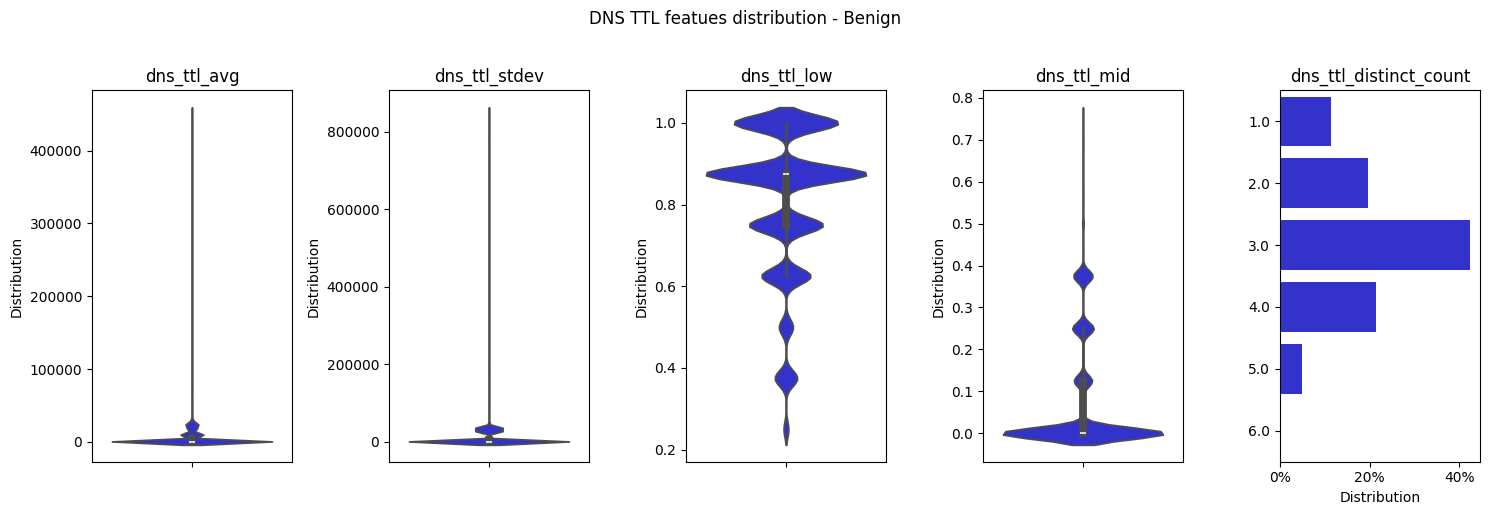

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_18360\348575436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_labels)


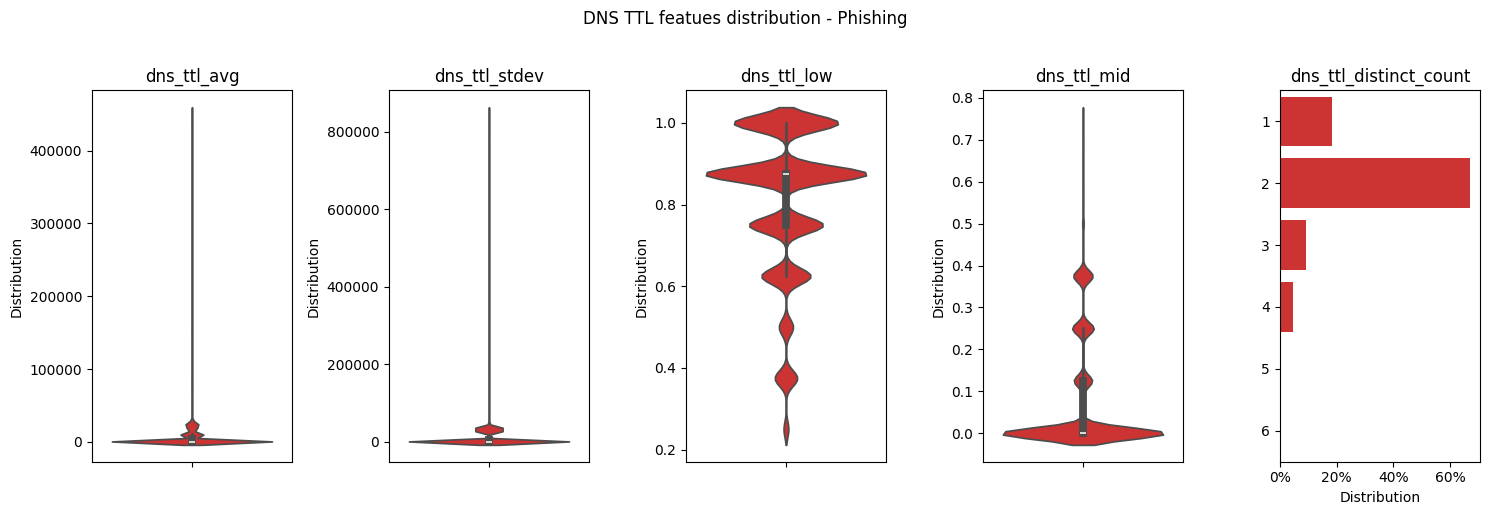

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming misp_ttls is your DataFrame

# Specify the features you want to plot
features_to_plot = [("dns_ttl_avg", 0), ("dns_ttl_stdev", 0), ("dns_ttl_low", 0), ("dns_ttl_mid", 0), ("dns_ttl_distinct_count", 1)]

def plot_ttls(df, color, df_name):
    fig, axes = plt.subplots(nrows=1, ncols=len(features_to_plot), figsize=(15, 5))
    # Loop through each feature and create a violin plot
    for i, [feature, discrete] in enumerate(features_to_plot):
        if discrete:
            data = pd.DataFrame(data=df[feature].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)))
            ax = sns.barplot(y=feature, x="proportion", ax=axes[i], data=data, color=color, saturation=0.6, orient="h")
            ax.set_ylabel("")
            ax.set_xlabel("Distribution")
            xticks_labels = [f"{x.get_text()}%" for x in ax.get_xticklabels()]
            ax.set_xticklabels(xticks_labels)
        else:
            sns.violinplot(y=misp_ttls[feature], ax=axes[i], color=color, saturation=0.6)
            axes[i].set_ylabel("Distribution")
            
        axes[i].set_title(feature)
    
    title = f"DNS TTL featues distribution - {df_name}"
    # Add a title to the entire plot
    plt.suptitle(title, y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"{image_path}/{title}.png")
    plt.savefig(f"{image_path}/{title}.pdf", format="pdf")
    # Show the plot
    plt.show()


plot_ttls(benign_ttls, "b", "Benign")
plot_ttls(misp_ttls, "r", "Phishing")

### Zone entropy & lenght

#### Calculate values 

In [32]:
from transformers._helpers import get_normalized_entropy

benign_dns["remarks"] = benign_dns["dns"].dropna().apply(lambda x: x.get("remarks"))
benign_dns["zone"] = benign_dns["remarks"].dropna().apply(lambda x: x.get("zone"))
benign_zent = benign_dns.dropna(subset=['zone'])
benign_zent = benign_zent.copy()
benign_zent["zone_entropy"] = benign_zent["zone"].apply(lambda dn: get_normalized_entropy(dn))
benign_zent["zone_len"] = benign_zent["zone"].str.len()

misp_dns["remarks"] = misp_dns["dns"].dropna().apply(lambda x: x.get("remarks"))
misp_dns["zone"] = misp_dns["remarks"].dropna().apply(lambda x: x.get("zone"))
misp_zent = misp_dns.dropna(subset=['zone'])
misp_zent = misp_zent.copy()
misp_zent["zone_entropy"] = misp_zent["zone"].apply(lambda dn: get_normalized_entropy(dn))
misp_zent["zone_len"] = misp_zent["zone"].str.len()

#### plot the results

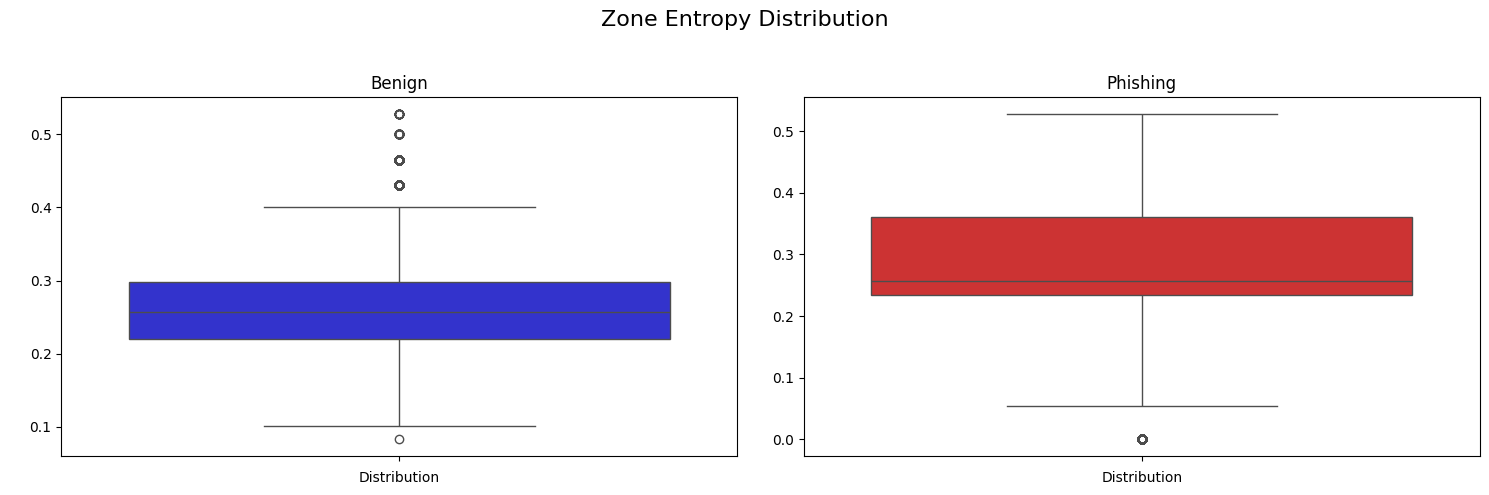

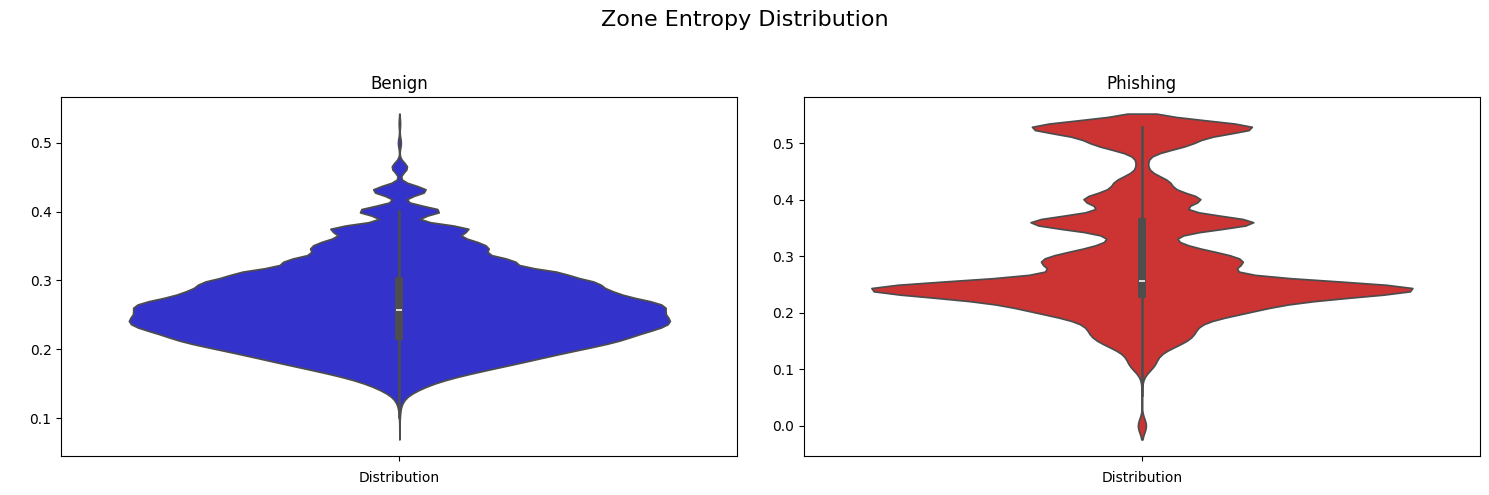

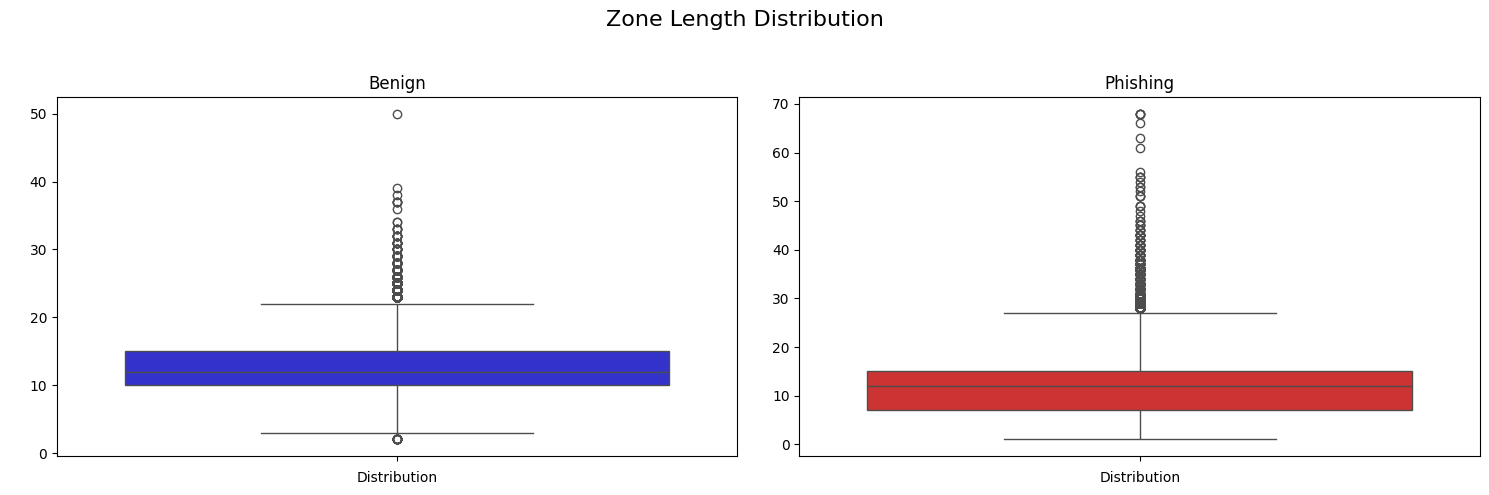

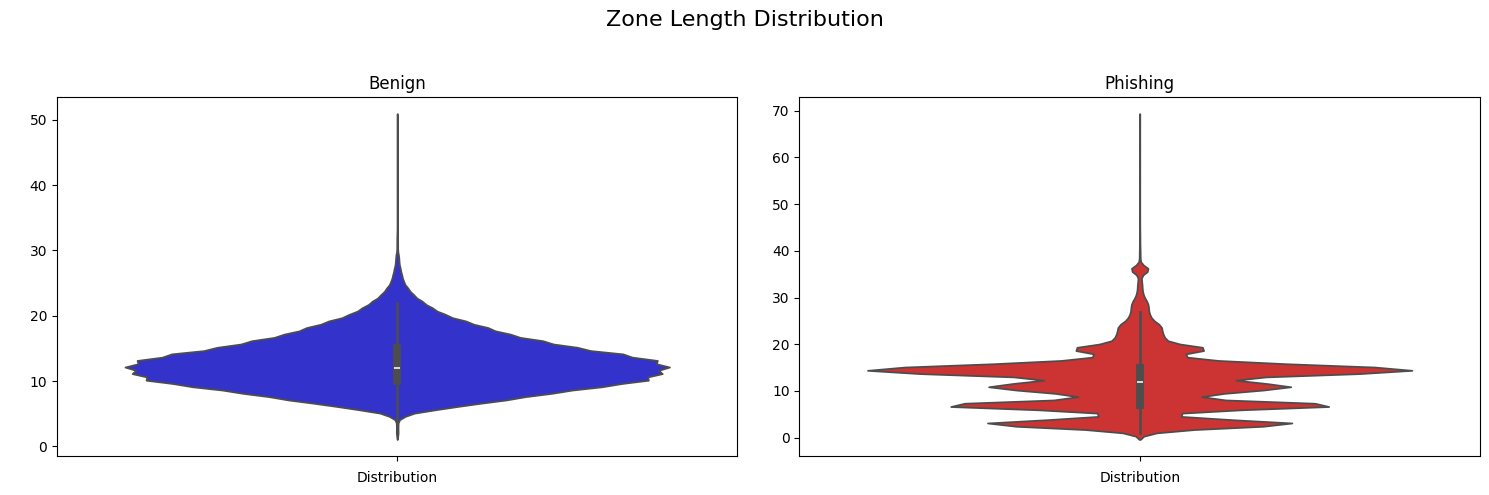

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature, feature_name in [("zone_entropy", "Zone Entropy"), ("zone_len", "Zone Length")]:
    for func, func_name in [(sns.boxplot, "boxplot"), (sns.violinplot, "violinplot")]:
        # Create subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        
        # Plot the violin plots
        func(y=benign_zent[feature], ax=axes[0], color="b", saturation=0.6)
        func(y=misp_zent[feature], ax=axes[1], color="r", saturation=0.6)
        
        # Set labels and title
        axes[0].set_title('Benign')
        axes[1].set_title('Phishing')
        
        title = f"{feature_name} Distribution"
        fig.suptitle(title, fontsize=16)
        
        axes[0].set_xlabel('Distribution')
        axes[1].set_xlabel('Distribution')
        
        axes[0].set_ylabel(' ')
        axes[1].set_ylabel(' ')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        plt.savefig(f"{image_path}/{title}_{func_name}.png")
        plt.savefig(f"{image_path}/{title}_{func_name}.pdf", format="pdf")
        # Show the plot
        plt.show()


### Zone leght

### GEO location

In [48]:
def compute_country_entropy(df):
    # Extract relevant columns
    id_country_data = df[["_id", "geo.country"]]

    # Drop rows with missing country data
    id_country_data = id_country_data.dropna(subset=["ip_data.geo.country"])

    # Group by ID and aggregate country data into lists
    id_country_groups = id_country_data.groupby("_id")["ip_data.geo.country"].agg(list)

    # Calculate country entropy for each ID
    entropy_values = id_country_groups.apply(lambda countries: entropy(np.unique(countries, return_counts=True)[1]))

    # Create a DataFrame with ID and corresponding entropy values
    entropy_df = pd.DataFrame({"_id": entropy_values.index, "country_entropy": entropy_values.values})

    return entropy_df



#### Countries

In [49]:
benign_top_n = 0.004
misp_top_n = 0.001

benign_coutry_dist = calculate_column_distribution(w_benign_ips, "geo.country", benign_top_n)
misp_coutry_dist = calculate_column_distribution(w_misp_ips, "geo.country", misp_top_n)

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_11416\3969064512.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


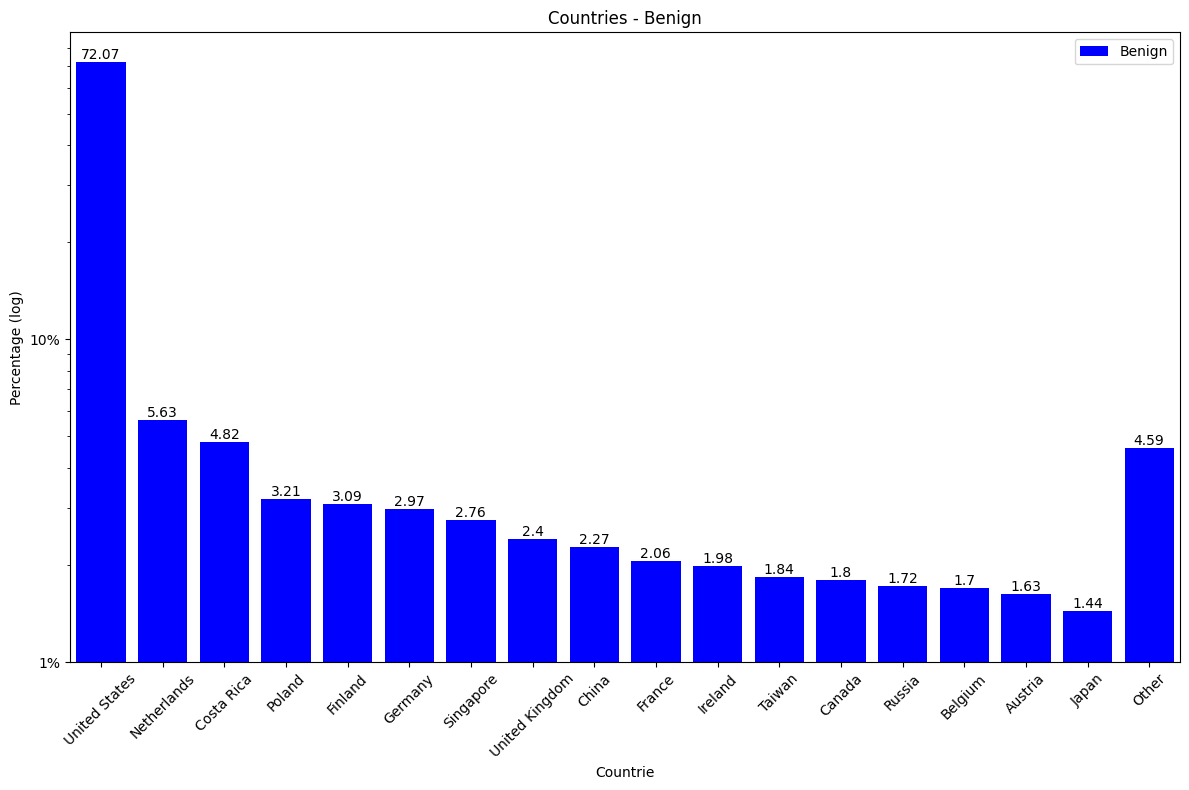

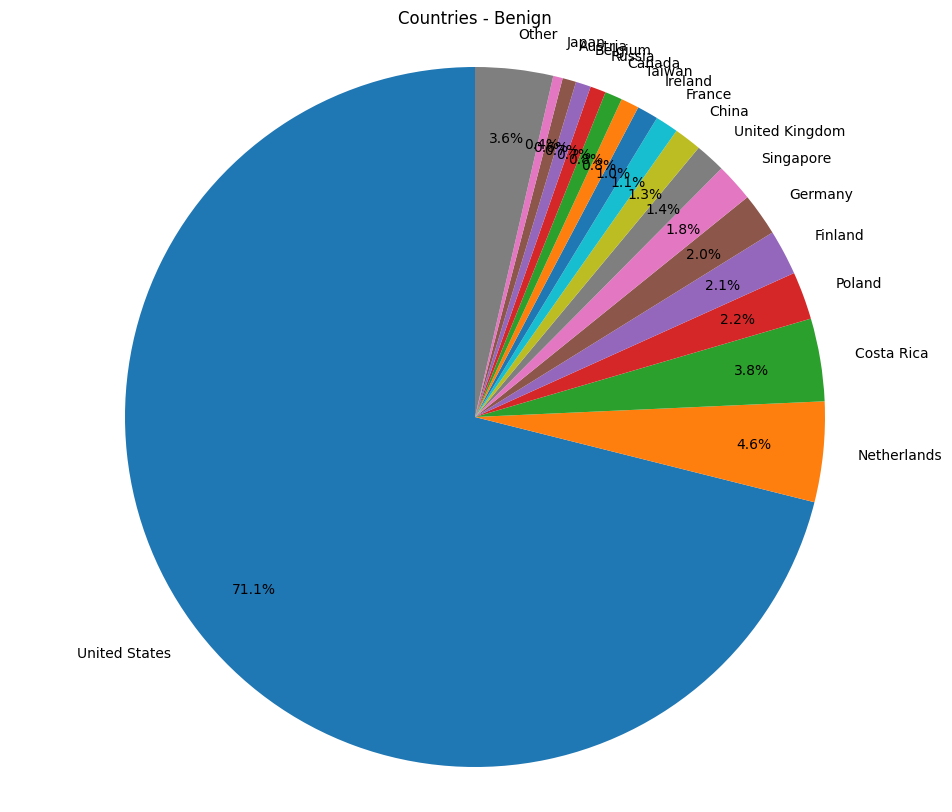

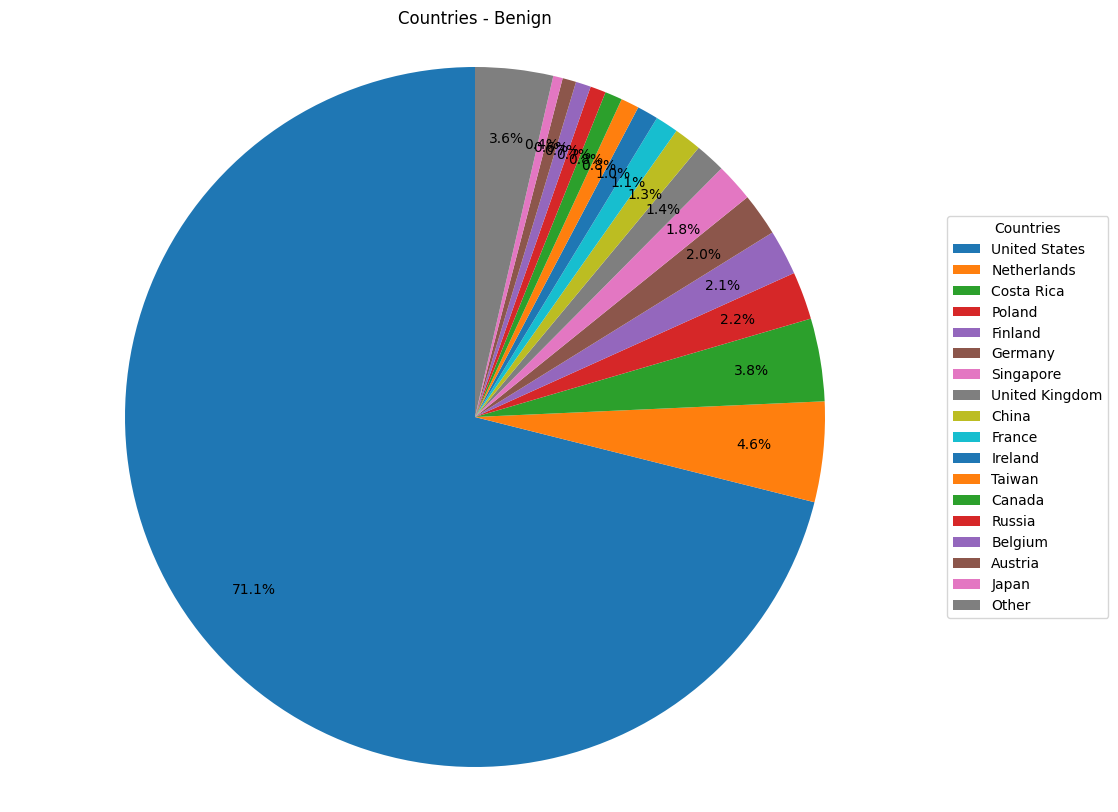

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_11416\3969064512.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


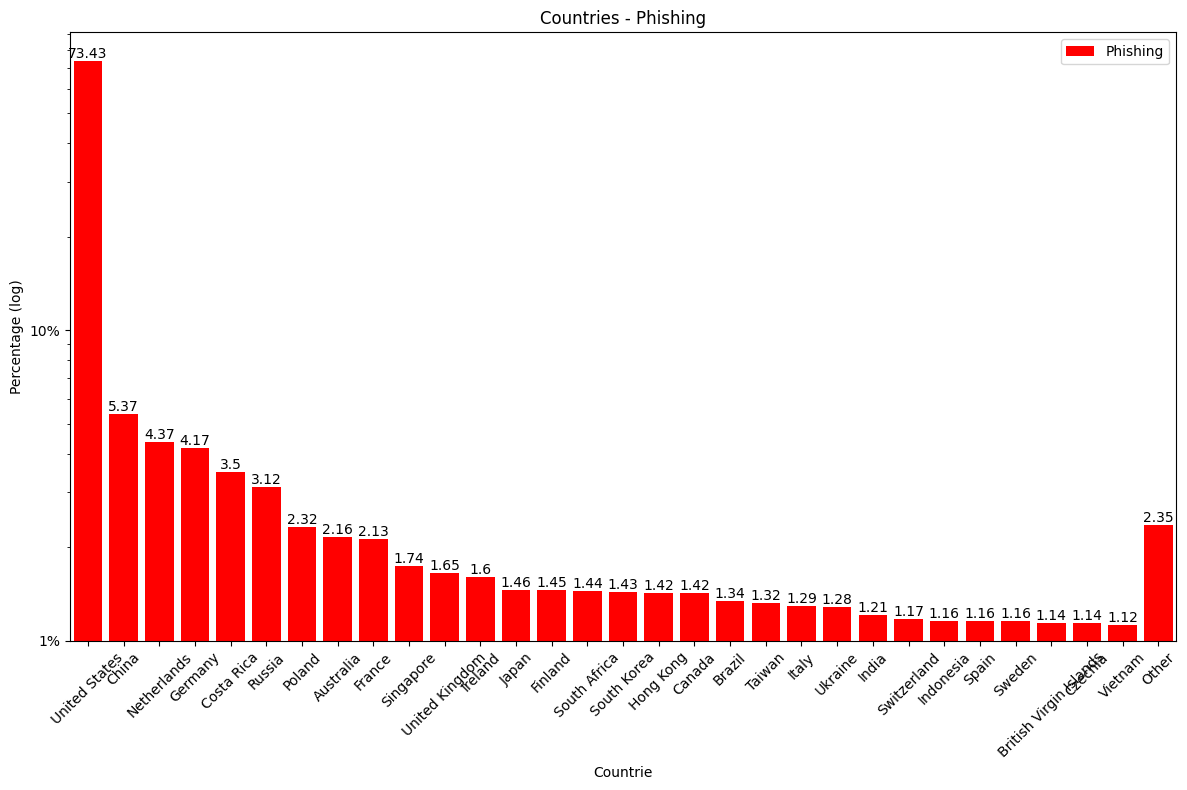

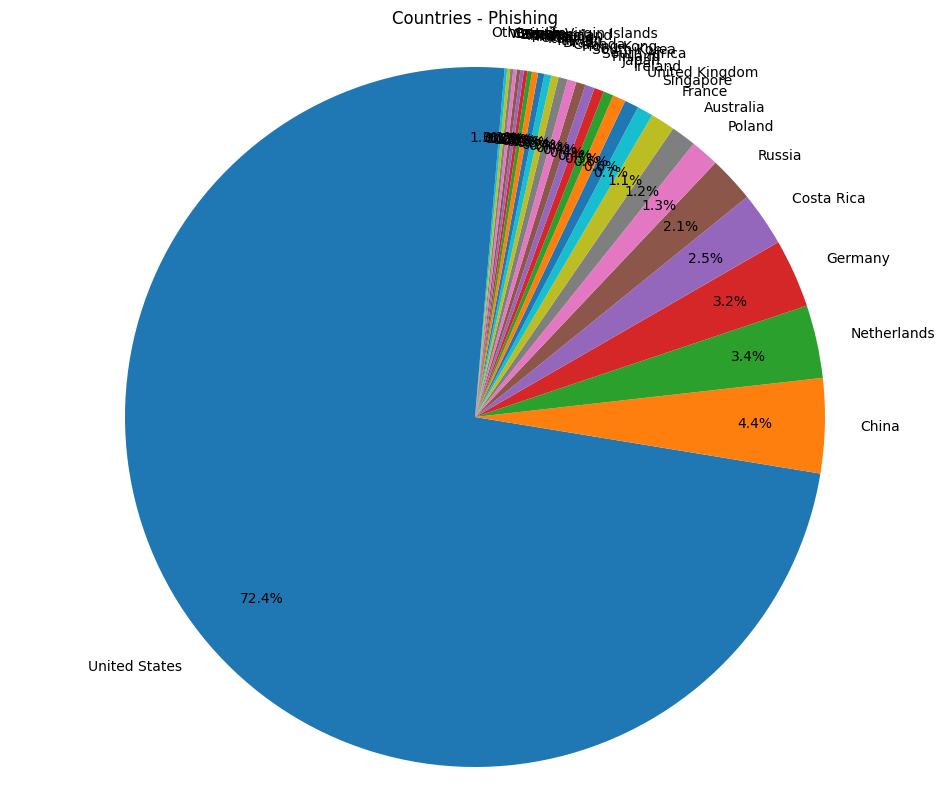

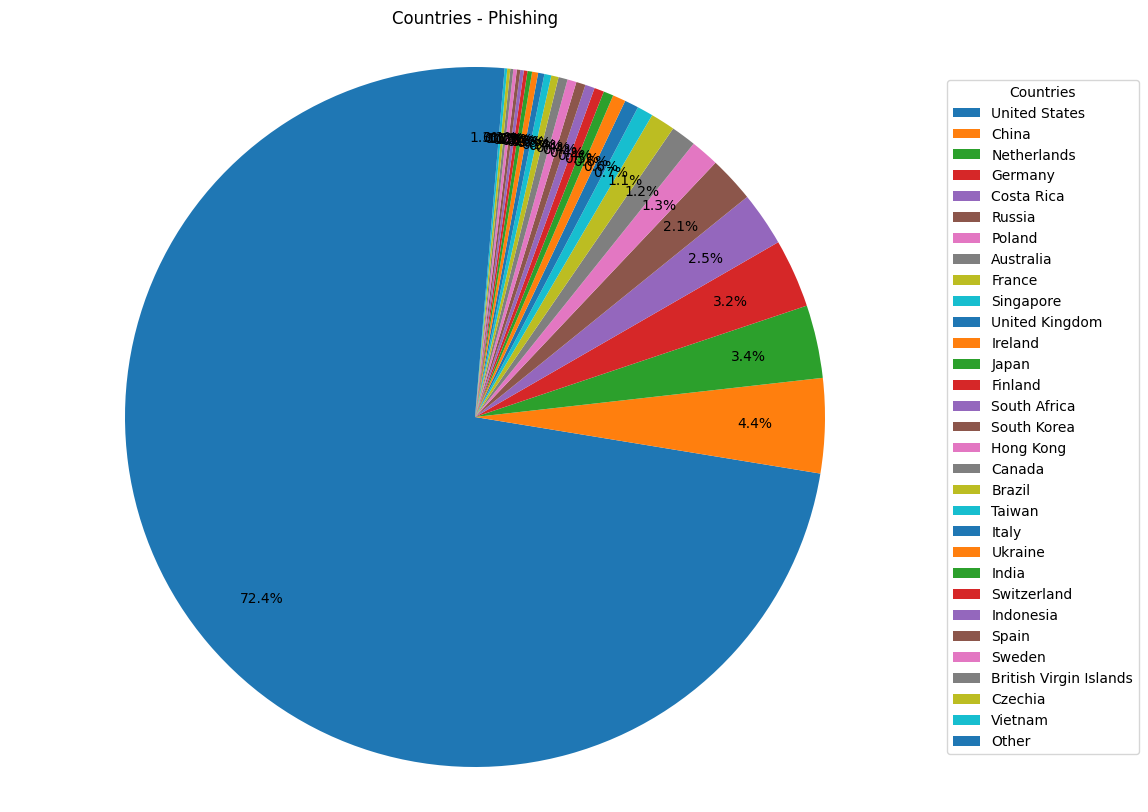

In [50]:
feature_name = "Countrie"
# Plot the Benign data
barplot_column_distribution(benign_coutry_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
piechart_column_distribution(benign_coutry_dist, feature_name, "Benign", color_map=plt.cm.Blues)
piechart_column_distribution(benign_coutry_dist, feature_name, "Benign", color_map=plt.cm.Blues, legend=True)
# Plot the Phishing data
barplot_column_distribution(misp_coutry_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
piechart_column_distribution(misp_coutry_dist, feature_name, "Phishing")
piechart_column_distribution(misp_coutry_dist, feature_name, "Phishing", legend=True)

In [52]:
print(w_benign_ips["geo.country"].value_counts()[:10])

geo.country
United States     87578
Germany            6198
China              4953
Netherlands        4787
Czechia            3626
Ireland            2865
Costa Rica         2273
United Kingdom     2052
Singapore          2027
Poland             1556
Name: count, dtype: int64


#### Countries the on World map

C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_15804\568705698.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


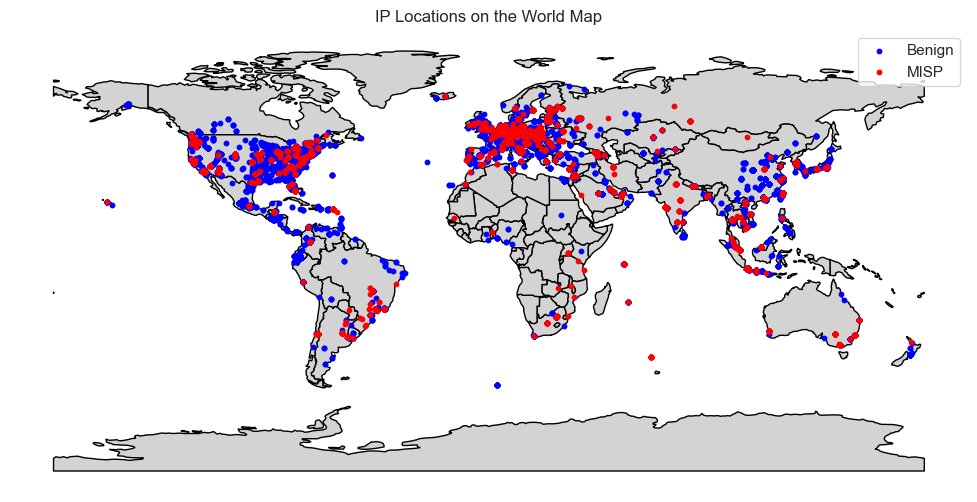

In [291]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Extract latitude and longitude from the 'geo' field
w_benign_ips['Latitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_benign_ips['Longitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_benign_ips = w_benign_ips.dropna(subset=["Latitude"])
w_benign_ips = w_benign_ips.dropna(subset=["Longitude"])

w_misp_ips['Latitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_misp_ips['Longitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_misp_ips = w_misp_ips.dropna(subset=["Latitude"])
w_misp_ips = w_misp_ips.dropna(subset=["Longitude"])

# Create a GeoDataFrame
gdf_benign = gpd.GeoDataFrame(w_benign_ips, geometry=gpd.points_from_xy(w_benign_ips['Longitude'], w_benign_ips['Latitude']))
gdf_misp = gpd.GeoDataFrame(w_misp_ips, geometry=gpd.points_from_xy(w_misp_ips['Longitude'], w_misp_ips['Latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map
gdf_benign.plot(ax=ax, color='blue', marker='o', markersize=10, label='Benign')
gdf_misp.plot(ax=ax, color='red', marker='o', markersize=10, label='MISP')

# Set axis labels and title
ax.set_axis_off()
plt.title('IP Locations on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.show()


C:\Users\Tomas Foltyn\AppData\Local\Temp\ipykernel_15804\2517946112.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


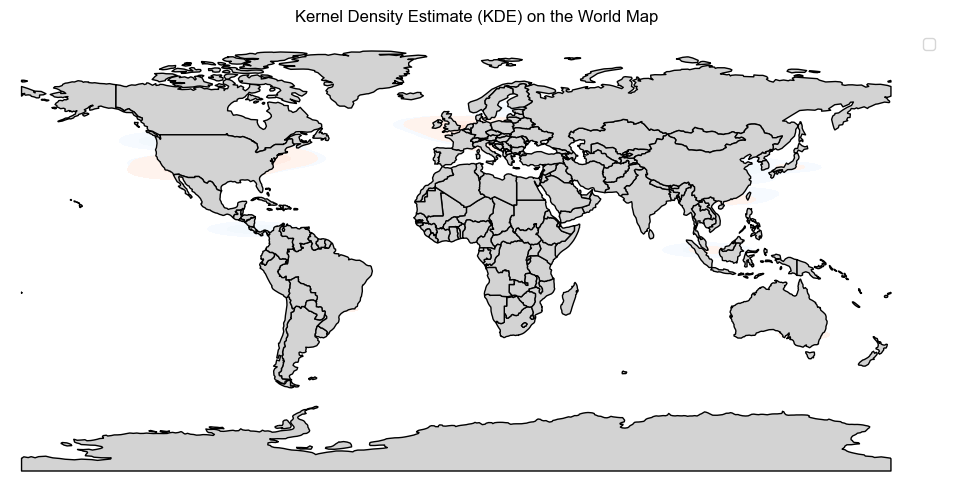

In [240]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `ip_data` is your DataFrame with the IP data schema

# Extract latitude and longitude from the 'geo' field
w_benign_ips['Latitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_benign_ips['Longitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_benign_ips = w_benign_ips.dropna(subset=["Latitude"])
w_benign_ips = w_benign_ips.dropna(subset=["Longitude"])

w_misp_ips['Latitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_misp_ips['Longitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_misp_ips = w_misp_ips.dropna(subset=["Latitude"])
w_misp_ips = w_misp_ips.dropna(subset=["Longitude"])

# Create a GeoDataFrame
gdf_benign = gpd.GeoDataFrame(w_benign_ips, geometry=gpd.points_from_xy(w_benign_ips['Longitude'], w_benign_ips['Latitude']))
gdf_misp = gpd.GeoDataFrame(w_misp_ips, geometry=gpd.points_from_xy(w_misp_ips['Longitude'], w_misp_ips['Latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 6))
sns.set_theme(style="whitegrid")

# Plot the KDE for Benign IPs
sns.kdeplot(data=gdf_benign, x="Longitude", y="Latitude", fill=True, cmap="Blues", ax=ax, common_norm=False, levels=10, label='Benign')

# Plot the KDE for MISP IPs
sns.kdeplot(data=gdf_misp, x="Longitude", y="Latitude", fill=True, cmap="Reds", ax=ax, common_norm=False, levels=10, label='MISP')

# Plot the world map
world.plot(ax=ax, edgecolor='black', color='lightgray')

# Set axis labels and title
ax.set_axis_off()
plt.title('Kernel Density Estimate (KDE) on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Tests

In [174]:
data = {
    "_id": [1, 2, 3],
    "ip_data": [
        {"geo": {"country": "US"}},
        {"geo": {"country": "CA"}},
        {"geo": {"country": "US"}},
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

In [35]:
test_misp_ips = w_misp_ips.copy()
# Explode the ip_data column
print(test_misp_ips.head())
test_misp_ips["og_id"] = test_misp_ips["_id"]
test_misp_ips = test_misp_ips.dropna(subset=["ip_data"])
test_misp_ips = test_misp_ips.apply(lambda row: pd.Series(row['ip_data']), axis=1).stack().reset_index(level=1, drop=True).reset_index()
test_misp_ips.columns = ['og_id', 'ip_data']

print(test_misp_ips.dtypes)
print(test_misp_ips)
# create new ids
test_misp_ips["_id"] = range(len(test_misp_ips))

# Flatten the ip_data column
test_misp_ips = pd.json_normalize(test_misp_ips['ip_data'])


       _id                                            ip_data  og_id
22413    0  [{'ip': '13.248.243.5', 'from_record': 'A', 'r...      0
36889    1                                                 []      1
33936    2                                                 []      2
21119    3  [{'ip': '18.130.80.173', 'from_record': 'A', '...      3
20135    4                                                 []      4
og_id       int64
ip_data    object
dtype: object
       og_id                                            ip_data
0      22413  [{'ip': '13.248.243.5', 'from_record': 'A', 'r...
1      36889                                                 []
2      33936                                                 []
3      21119  [{'ip': '18.130.80.173', 'from_record': 'A', '...
4      20135                                                 []
...      ...                                                ...
36049   7127                                                 []
36050  16396  [{'ip': '1

In [41]:
test_misp_ips = w_misp_ips.copy()
test_misp_ips.iloc[3]["ip_data"]

"[{'ip': '18.130.80.173', 'from_record': 'A', 'remarks': {'rdap_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 36, 885000), 'asn_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 41, 67000), 'geo_evaluated_on': datetime.datetime(2023, 9, 10, 12, 22, 35, 841000), 'rep_evaluated_on': None, 'icmp_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 41, 67000), 'is_alive': False, 'average_rtt': 0.0, 'ports_scanned_on': None}, 'rdap': {'handle': 'NET-18-130-0-0-2', 'parent_handle': 'NET-18-32-0-0-1', 'name': 'AMAZON-LHR', 'whois_server': 'whois.arin.net', 'type': 'ip network', 'terms_of_service_url': 'https://www.arin.net/resources/registry/whois/tou/', 'copyright_notice': 'Copyright 1997-2023, American Registry for Internet Numbers, Ltd.', 'description': [], 'last_changed_date': datetime.datetime(2021, 2, 10, 14, 46, 11), 'registration_date': datetime.datetime(2018, 2, 22, 21, 1, 30), 'expiration_date': None, 'url': 'https://rdap.arin.net/registry/ip/18.130.0.0', 'rir': 'arin', 'enti

In [200]:
test_misp_ips["rdap.ip_version"]

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
50372    4.0
50373    4.0
50374    4.0
50375    4.0
50376    6.0
Name: rdap.ip_version, Length: 50377, dtype: float64

In [33]:
import pandas as pd

# Assuming 'ip_data' is a column containing lists
df = pd.DataFrame({
    '_id': [0, 1, 2],
    'ip_data': [[{'ip': '13.248.243.5'}, {'ip': '18.130.80.173'}], [], []]
})

df = df[df['ip_data'].apply(lambda x: bool(x))]

# Store the original id
df['og_id'] = df['_id']

# Explode the 'ip_data' column
df_exploded = df.apply(lambda row: pd.Series(row['ip_data']), axis=1).stack().reset_index(level=1, drop=True).reset_index()
df_exploded.columns = ['og_id', 'ip_data']

print(df_exploded)



   og_id                  ip_data
0      0   {'ip': '13.248.243.5'}
1      0  {'ip': '18.130.80.173'}


In [32]:
df_exploded["og_id"]

0    0
1    0
Name: og_id, dtype: int64